In [2]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pandas as pd

import itertools
import os

from ip3_ca_ode_cfg import *
import cfg

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

diversity_colors = {
#     'SP': '#5dbcd2', #blue
    'SP': '#2b8bfb',
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

In [8]:


def plot_deriv_speed(speed, x_var, y_var, x_range=None, y_range=None, ax=None, Gstar=0.1, glutamate=False,
                    plot_from_fp=True, plot_from_exp=True, fix_idx=40, absolute=True, plot_labels=True):
    '''
    speed: variable to check speed of, can give label or idx
    x_var, y_var: the variables that will be plotted against, can give labels or idxs
    x_range, y_range: optionally pass in manual ranges to use
    ax: optionally pass an axis to plot on
    Gstar: whether we are working with Gstar inputs or glutamate inputs
    plot_from_fp: plot the start of fp
    plot_from_pulse: plot the a part of pulse exp
    fixes: index from which to start fixes from
    absolute: whether to give absolute speed
    '''
#     #set fixed data from bifurcation data
#     data = load_bifurcation_data('Gstar_bifurcation_all.dat')
#     #6 -> c vals
#     #7 -> c_tot vals
#     #8 -> h vals
#     #9 -> p vals
#     idx = np.argmax(data[3] >= Gstar)
#     fixes = [data[6][idx], data[7][idx], data[8][idx], data[9][idx]]
    
    cfg.input_max = Gstar
    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    fixes = [cfg.c[fix_idx], cfg.c_tot[fix_idx], cfg.h[fix_idx], cfg.p[fix_idx]]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
    X, Y = np.zeros((spacing, spacing)), np.zeros((spacing, spacing))
    speeds = np.zeros((spacing, spacing))
    
    if type(x_var) != type(0):
        x_var = var_names.index(x_var)
    if type(y_var) != type(0):
        y_var = var_names.index(y_var)
    if type(speed) != type(0):
        speed = var_names.index(speed)
        
    if x_range is None:
        x_range = ranges[x_var]
    if y_range is None:
        y_range = ranges[y_var]
        
#     print(y_range)
        
    #set the fixed inputs
    x_input = [0, 0, 0, 0]
    for i in range(len(var_names)):
        if i == x_var or i == y_var:
            continue
        else:
            x_input[i] = fixes[i]
    
    
    for i in range(spacing):
        for j in range(spacing):
                        
            x_input[x_var] = x_range[j]
            x_input[y_var] = y_range[i]
            X[i, j] = x_range[j]
            Y[i, j] = y_range[i]
            
            if Gstar:
                dx = ip3_ca_ode_equations(0, x_input, Gstar=Gstar)
                
#             if j == test:
#                 print(x_input)
#                 print(np.abs(dx[speed]))
            
            if absolute:
                speeds[i, j] = np.abs(dx[speed])
            else:
                speeds[i, j] = dx[speed]
    extent = [np.min(x_range), np.max(x_range), np.min(y_range), np.max(y_range)]
    ax.imshow(np.flip(speeds, axis=0), extent=extent, aspect='auto')
    
    if plot_labels:
        ax.set_xlabel(labels[x_var])
        ax.set_ylabel(labels[y_var], rotation=0, labelpad=30)
    
    if plot_from_fp:
        cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
        run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
        for i in range(5):
            ax.scatter(fps[x_var], fps[y_var], c='green', marker='x', s=100)
            ax.plot(getattr(cfg, var_names[x_var])[:plot_len_2], getattr(cfg, var_names[y_var])[:plot_len_2], c='green')
        cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
    
    if plot_from_exp:
        cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
        run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
        for i in range(5):
            ax.scatter(fixes[x_var], fixes[y_var], c='red', marker='x', s=100)
            ax.plot(getattr(cfg, var_names[x_var])[starting_idx:ending_idx], 
                       getattr(cfg, var_names[y_var])[starting_idx:ending_idx], c='red')
    return X, Y, speeds, x_range, y_range, extent
#     return y_range


def plot_deriv_quiver(x_var, y_var, plot_from_exp=True, fix_idx=40, Gstar=0.1, ax=None,
                     x_range=None, y_range=None):
    cfg.input_max = Gstar
    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    fixes = [cfg.c[fix_idx], cfg.c_tot[fix_idx], cfg.h[fix_idx], cfg.p[fix_idx]]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if type(x_var) != type(0):
        x_var = var_names.index(x_var)
    if type(y_var) != type(0):
        y_var = var_names.index(y_var)
        
    if x_range is None:
        x_range = ranges[x_var]
    if y_range is None:
        y_range = ranges[y_var]

    arrow_spacing = 10
    x_range = np.linspace(np.min(x_range), np.max(x_range), arrow_spacing)
    y_range = np.linspace(np.min(y_range), np.max(y_range), arrow_spacing)
    U = []
    V = []
    X = []
    Y = []

    #set the fixed inputs
    x_input = [0, 0, 0, 0]
    for i in range(len(var_names)):
        if i == x_var or i == y_var:
            continue
        else:
            x_input[i] = fixes[i]

    for i in range(arrow_spacing):
        for j in range(arrow_spacing):
            x = x_range[i]
            y = y_range[j]
            X.append(x)
            Y.append(y)
            x_input[2] = x
            x_input[3] = y

            dx = ip3_ca_ode_equations(0, x_input, Gstar=Gstar)

            U.append(dx[2])
            V.append(dx[3])

    # C = np.linalg.norm(np.array([arrows_h, arrows_p]), axis=0)
    C = np.hypot(U, V)
    ax.quiver(X, Y, U, V, C)
    
    if plot_from_exp:
        cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
        run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
        for i in range(5):
            ax.scatter(fixes[x_var], fixes[y_var], c='red', marker='x', s=100)
            ax.plot(getattr(cfg, var_names[x_var])[starting_idx:ending_idx], 
                       getattr(cfg, var_names[y_var])[starting_idx:ending_idx], c='red')


def run_Gstar_kick_experiment(kick_var='p', kick_val=0.01, kick_t=30, t_total=200, max_step=0.5):
    '''
    Perform a kick experiment using Gstar controlled
    '''
    run_Gstar_controlled_experiment('pulse', t_f=kick_t, max_step=max_step)
    getattr(cfg, kick_var)[-1] += kick_val
    continue_Gstar_controlled_experiment('pulse', t_cont=t_total-kick_t, max_step=max_step)
    
    
    
    
def end_first_response(t, c):
    peaks, troughs = calcium_peaks_and_troughs(t, c)
    response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total =\
                            calcium_response_characteristics(t, c, peaks)

    #next we are trying to decide between SP and PL response
    #the major peak duration is the time between response start and the first time
    #the derivative is closest to zero after being negative (after the first peak)
    #or the first peak in c', whichever is sooner
    c_deriv = np.diff(c) / np.diff(t)
    c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
    t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
    first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative

    #check if deriv never turns positive
    if np.all(c_neg_deriv < 0):
        first_pos_deriv = response_end_index - peaks[0]

    #check for peaks of c_neg_deriv, also can count as end of first response, whichever is first
    c_neg_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0]

    if len(c_neg_deriv_peaks) > 0:
        first_deriv_peak = c_neg_deriv_peaks[0]
        if first_pos_deriv == 0:
            first_pos_deriv = min(first_deriv_peak, response_end_index-peaks[0])
        else:
            first_pos_deriv = min(first_pos_deriv, first_deriv_peak, response_end_index-peaks[0])

    end_first_response = first_pos_deriv + peaks[0]
    t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative

    return end_first_response


def classification_simulation_with_row(df_row, t_0=0, t_f=400, max_step=0.1, input_type='glut',
                                      c_tot=1, poisson_start=False, kpkm=[1, 1]):
    '''
    Run the ip3 simulation with parameters given from pandas dataframe row
    c_tot: control the initial c_tot condition
    poisson_start: whether to use initial condition generated by poisson start
    kpkm: factors to change the kp and km parameters ([30, 10] might be good for correct sensitivity)
    '''
    all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
    kp = 0.03
    km = 0.04
    
    if poisson_start:
        load_experiment('poisson/rate_0.2_conc_10')
        cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    
#     cfg.all_init[1] = cfg.all_init[1] * c_tot
    cfg.kp = kp * kpkm[0]
    cfg.km = km * kpkm[1]
    
    cfg.A = df_row['A']
    cfg.d_rise = df_row['d_rise']
    cfg.d_decay = df_row['d_decay']
    cfg.r_rise = df_row['r_rise']
    cfg.r_decay = df_row['r_decay']

    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'Gstar'):
        sol = run_Gstar_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step)
        
    cfg.all_init = all_init
    cfg.kp = kp
    cfg.km = km
    
    return sol



def classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_0=0, t_f=400, max_step=0.2,
                                       input_type='glut'):
    '''
    Run the full system simulation for values to shape glutamate transient
    
    A, d_rise, d_decay, r_rise, r_decay: input curve parameters
    input_type: 'glut'/'ip3' - what system to run control for
    '''
    cfg.A = A
    cfg.d_rise = d_rise
    cfg.d_decay = d_decay
    cfg.r_rise = r_rise
    cfg.r_decay = r_decay
    
    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step, classification=True)
    return sol
    
    
    

'''
------------------------
Classification Functions
------------------------
These functions will be used to tell use what type of calcium response we have
as well as the IP3 characteristics
'''

def ip3_characteristics(t_0, t_f):
    '''
    This function returns some characteristic information about the ip3 curve
    It uses the globally set ip3 curve parameters (d_rise, d_decay, r_rise, r_decay)
    which are set using set_ip3_curve_manual, then ip3_curve_input gives the actual ip3 curve
    
    returns: ip3_total, ip3_amplitude, t_peak, t_duration
    ip3_total: total amount of ip3 in the transient curve
    ip3_amplitude: the height of ip3 at peak
    t_peak: the time of peak
    t_duration: the total time the ip3 transient lasted
    '''
    #get the ip3 curve
    t = np.arange(t_0, t_f, 0.1)
    p = np.zeros(len(t))
    for i in range(len(t)):
        p[i] = ip3_curve_input(t[i])
    
    ip3_total = np.sum(p) / len(p) * t_f #mean instantaneous ip3 multiplied by total time
    
    peaks, _ = scipy.signal.find_peaks(p) #find the index of maximum value of ip3
    if(len(peaks) > 0):
        peak = peaks[0]
    else:
        peak = False
        
    ip3_amplitude = p[peak]
    t_peak = t[peak]
    
    t_start_index = np.argmax(p > 0) #find first occurence that ip3 > 0
    t_end_index = peak + np.argmax(p[peak:] < 0.005) #find first time after the peak that ip3 < 0.005
    t_duration = t[t_end_index] - t[t_start_index]
    
    if(peak == False):
        t_duration = t_f #if there are no peaks, the "duration" is the entire simulation
    
    return ip3_total, ip3_amplitude, t_peak, t_duration
    

def calcium_peaks_and_troughs(t, c, index=True):
    '''
    Determine where the peaks and troughs are in the calcium response
    Pass t and c given by the numerical ODE solver
    index: True/False, if True will return indices of peaks and troughs, rather than values
    
    returns: 
      (index == False): t_peaks, c_peaks, t_troughs, c_troughs
      (index == True): peaks, troughs
    '''
    base_c = c[0]
    response_start_index = np.argmax(c > 1.4 * base_c) #we label the first time the calcium is 1.4 times base level
                                                        #as the start of the calcium response
    peaks, _ = scipy.signal.find_peaks(c) #note that these functions find the indices of peaks and troughs
    peaks = peaks[t[peaks] > cfg.t_star] #real peaks are those that happend after the start of the ip3 signal
    troughs, _ = scipy.signal.find_peaks(-c)
    true_troughs = []
    
    #the only troughs that we should count are the ones that lie between two peaks
    t_first_peak = t[peaks[0]]
    t_last_peak = t[peaks[-1]]
    for trough in troughs:
        if(t_first_peak < t[trough] and t[trough] < t_last_peak):
            true_troughs.append(trough)
    
    if(index):
        return peaks, true_troughs
    else:
        #convert indices to values
        t_peaks = t[peaks]
        c_peaks = c[peaks]
        t_troughs = t[true_troughs]
        c_troughs = c[true_troughs]        
        return t_peaks, c_peaks, t_troughs, c_troughs
    

    
def calcium_response_characteristics(t, c, peaks):
    '''
    Get characteristics of the calcium curve
    '''
    #determine start of calcium response to be 2x the baseline value
    base_c = c[1]
    response_start_index = np.argmax(c > 2 * base_c)
    last_peak = peaks[-1]
    response_end_index = last_peak + np.argmax(c[last_peak:] < 2 * base_c) #find end of response
    #if always above 2 * baseline value, need to manually set response end as the end of time
    if np.all(c[last_peak:] >= 2 * base_c):
        response_end_index = len(t) - 1
    
    t_response_start = t[response_start_index]
    t_response_end = t[response_end_index]
    t_duration = t_response_end - t_response_start
    
#     base_c = c[response_start_index - 3] #our baseline for calcium is the value of c before response starts
    max_height_c = np.max(c) - base_c
    
    c_means = (c[response_start_index : response_end_index - 1] +\
               c[response_start_index + 1 : response_end_index]) / 2
    c_total = np.sum(np.diff(t[response_start_index : response_end_index]) * c_means)
    
    return response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total
    
    


def visualize_classification(t, c, x_max=150, ret=False, ax=None, peak_priority=False):
    '''
    Visualize what the algorithm is observing to classify a response
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
#     ax.figure(figsize=(8,8))
    ax.plot(t, c)
    ax.plot(t[1:], np.diff(c) / np.diff(t))
    
    vis_dict, response = calcium_response_classification(t, c, vis=True, peak_priority=peak_priority)
    
    if(len(vis_dict['mp_peaks']) > 0):
        ax.scatter(t[vis_dict['mp_peaks']], c[vis_dict['mp_peaks']], c='blue')
    if(len(vis_dict['mp_troughs']) > 0):
        ax.scatter(t[vis_dict['mp_troughs']], c[vis_dict['mp_troughs']], c='red')
    if(vis_dict['end_first_response'] is not None):
        ax.scatter(t[vis_dict['end_first_response']], c[vis_dict['end_first_response']], c='green')
        ax.scatter(t[vis_dict['end_first_response']], [0], c='green')

#     print(t[vis_dict['end_first_response']])
    ax.scatter(t[vis_dict['response_start_index']], c[vis_dict['response_start_index']], c='black')
    ax.scatter(t[vis_dict['response_end_index']], c[vis_dict['response_end_index']], c='black')
    
    ax.plot([0, x_max], [0, 0], '--', c='green')
    ax.set_xlim([0, x_max])
    
    print(response)
    if(ret):
        return vis_dict

    

def calcium_response_classification(t, c, vis=False, peak_priority=False, verbose=False):
    '''
    Classify the type of calcium response given a specific ip3 transient curve
    vis: if this is set to True, at each classification we will instead return a dictionary
        holding the characteristics being used to identify the peak for visualization
        also we will print out information that helps to identify what the algorithm sees
    '''
    
    def conditional_vis_return(response, vis_dict, vis):
        '''
        simple helper function to return the appropriate thing
        '''
        if(vis):
            return vis_dict, response
        else:
            return response
    try:
        ll_duration = 70 #how long the calcium elevation has to be to be classified as long lasting
    #     plt.plot(t, c)
        peaks, troughs = calcium_peaks_and_troughs(t, c)
        response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total =\
                                    calcium_response_characteristics(t, c, peaks)
        t_response_start = t[response_start_index]
        t_response_end = t[response_end_index]    
    except:
        return conditional_vis_return('O (too small)', {}, vis)
    
    vis_dict = {
        'response_start_index': response_start_index,
        'response_end_index': response_end_index,
        'mp_peaks': [],
        'mp_troughs': [],
        'end_first_response': None,
        'base_c': base_c
    }
    
    if(len(peaks) == 0):
        #if there are no peaks, no response
        return conditional_vis_return('NR', vis_dict, vis)
    
    if(t_duration > 200):
        #calcium response duration too long
        return conditional_vis_return('O (too long)', vis_dict, vis)
    if(np.max(c[peaks]) < 0.4):
        #calcium peaks are too small
        return conditional_vis_return('O (too small)', vis_dict, vis)
    if(np.max(c[peaks]) > 3.5):
        #calcium peaks are too large
        return conditional_vis_return('O (too large)', vis_dict, vis)
 
    mp_peaks = []
    mp_troughs = []

    if peak_priority:
        #with peak priority, we count peaks and troughs differently.
        #troughs are those that reach 50% of the prior peak
        #peaks are those that are above 15% between prior peak and trough
        for i, peak in enumerate(peaks):
            real_peak_index = 0
            if(i == 0):
                #first peak is always real
                mp_peaks.append(peak)
                
            else:
                #check if there is a trough to match the next peak to
                if len(mp_peaks) == len(mp_troughs):
                    trough_c = c[mp_troughs[-1]]
#                     prev_peak_c = c[mp_peaks[-1]]
                    prev_peak_c = c[peaks[i-1]]
                    peak_c = c[peak]
                    clear_c_height = 0.09 * (prev_peak_c - trough_c) + trough_c
                    if peak_c > clear_c_height:
                        mp_peaks.append(peak)
                        real_peak_index += 1
                
            #check if there is a trough reaching <50% of prior peak
            #only check if there is a valid peak before the trough to check against
            if i < len(troughs) and real_peak_index == len(mp_troughs):
                trough = troughs[i]
                prev_peak_c = c[mp_peaks[real_peak_index]]
                trough_c = c[trough]
                if (trough_c - base_c) < (0.5 * (prev_peak_c - base_c)):
                    #trough reached below 50% of previous valid peak
                    mp_troughs.append(trough)
            #check if we should replace the trough with a lower one
            elif i < len(troughs):
                trough = troughs[i]
                trough_c = c[trough]
                prev_trough_c = c[mp_troughs[-1]]
                if trough_c < prev_trough_c:
                    mp_troughs[-1] = trough
        
        #Finally go through one more time and only keep troughs that have peaks after
        mp_troughs = mp_troughs[:(len(mp_peaks) - 1)]
            
    else:
        #real peaks are those that reach >5% of their adjacent peak
#         print(c[peaks])
        for i, peak in enumerate(peaks):
#             print(c[peak] - base_c) 
            real_peak_index = 0
            if(i == 0):
                #the first peak is always real
                mp_peaks.append(peak)
            elif((c[peak] - base_c) > 0.05 * (c[mp_peaks[real_peak_index]] - base_c)):
#                 if(vis):
#                     print('Previous peak {}, next peak {}'.format(
#                         (c[mp_peaks[real_peak_index]], c[peak] - base_c)
#                     ))
#                     print('Previous peak %.2f' % c[mp_peaks[real_peak_index]])
                #otherwise, check is this peak is >5% of the adjacent (real) peak
                mp_peaks.append(peak)
                real_peak_index += 1

        #real troughs are those that reach <50% of their surrounding max peaks
        for i, trough in enumerate(troughs):
            #get the peaks that are to the left and right of each trough
            left_peak = peaks[i]
            right_peak = peaks[i+1]
            if(left_peak in mp_peaks and right_peak in mp_peaks):
                max_peak = np.max([c[left_peak], c[right_peak]]) - base_c
                min_peak = np.min([c[left_peak], c[right_peak]]) - base_c
                if(c[trough] - base_c < 0.5 * min_peak):
                    mp_troughs.append(trough)
    vis_dict['mp_troughs'] = mp_troughs
    vis_dict['mp_peaks'] = mp_peaks

    last_peak = mp_peaks[-1]
    #recalculate reponse end using mp_peaks instead
    _, response_end_index, _, _, _, _ = calcium_response_characteristics(t, c, mp_peaks)
    
    t_response_end = t[response_end_index]
    
    #NOTE: UNSURE IF THIS IS IMPORTANT ATM
#     if(len(mp_troughs) >= len(mp_peaks)):
#         print('Warning: weird case reached')
#     if(len(peaks) > len(mp_peaks)):
#         print('Case: fewer mp_peaks')

    #make a list of times [response_start, mp_troughs, response_end]
    #so we can check if the distance between any of these start/end/trough points
    #is greater than the LL response limit
    
    
    response_checkpoints = np.append(t_response_start, t[mp_troughs])
    response_checkpoints = np.append(response_checkpoints, t_response_end)
    if( (np.diff(response_checkpoints) > ll_duration).any() ):
        if(verbose):
            print('Some response segment was longer than 70s')
        #check if any of these time distances is greater than ll_duration
        return conditional_vis_return('LL', vis_dict, vis)

    
    
    #next we are trying to decide between SP and PL response
    #the major peak duration is the time between response start and the first time
    #the derivative is closest to zero after being negative (after the first peak)
    #or the first peak in c', whichever is sooner
    c_deriv = np.diff(c) / np.diff(t)
    c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
    t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
    first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative

    #check if deriv never turns positive
    if np.all(c_neg_deriv < 0):
        first_pos_deriv = response_end_index - peaks[0]

    #check for peaks of c_neg_deriv, also can count as end of first response, whichever is first
    c_neg_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0]

    if len(c_neg_deriv_peaks) > 0:
        first_deriv_peak = c_neg_deriv_peaks[0]
        if first_pos_deriv == 0:
            first_pos_deriv = min(first_deriv_peak, response_end_index-peaks[0])
        else:
            first_pos_deriv = min(first_pos_deriv, first_deriv_peak, response_end_index-peaks[0])

    end_first_response = first_pos_deriv + peaks[0]
    t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative

    vis_dict['end_first_response'] = end_first_response
    
    
    
    
    
    if(not peak_priority and len(mp_troughs) > 0):
        if(verbose):
            print('At least one valid trough <50% height of neighboring peaks')
        #otherwise, if we did indeed find any valid troughs and we know the
        #duration is short enough, we have found a MP
        return conditional_vis_return('MP', vis_dict, vis)
    elif(peak_priority and len(mp_peaks) > 1):
        if(verbose):
            print('At least 2 valid peaks')
        return conditional_vis_return('MP', vis_dict, vis)
    else:
        if(verbose):
            print('No valid troughs that were <50% height of neighboring peaks')
#         #now we are in the case that there are no valid troughs, i.e. only 1 valid peak
#         #first check if the whole response stays >15% max response for > ll_duration
#         c_levelled = c - base_c #c_levelled is the calcium response minus the base
#         response_15_index = c_levelled > max_height_c * 0.15
#         t_15 = t[response_15_index]
#         t_15_duration = t_15.max() - t_15.min() #this is the duration that response stays
#                                                 #above 15% of max
#         if(t_15_duration > ll_duration):
#             if(vis):
#                 print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
#             return conditional_vis_return('LL', vis_dict, vis)
        
        ll_c = c - base_c
        for i, peak in enumerate(mp_peaks):
            ll_c[peak:] = ll_c[peak:] - ((c[peak] - base_c) * 0.15)
            if i > 0:
                ll_c[peak:] = ll_c[peak:] + ((c[mp_peaks[i - 1]] - base_c) * 0.15)
        t_15 = t[ll_c > 0]
        t_15_duration = t_15.max() - t_15.min()
        if(t_15_duration > ll_duration):
            if(verbose):
                print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
            return conditional_vis_return('LL', vis_dict, vis)
        
        #next we are trying to decide between SP and PL response
        #the major peak duration is the time between response start and the first time
        #the derivative is closest to zero after being negative (after the first peak)
        #or the first peak in c', whichever is sooner
        c_deriv = np.diff(c) / np.diff(t)
        c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
        t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
        first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative
        
        #check if deriv never turns positive
        if np.all(c_neg_deriv < 0):
            first_pos_deriv = response_end_index - peaks[0]

        #check for peaks of c_neg_deriv, also can count as end of first response, whichever is first
        c_neg_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0]

        if len(c_neg_deriv_peaks) > 0:
            first_deriv_peak = c_neg_deriv_peaks[0]
            if first_pos_deriv == 0:
                first_pos_deriv = min(first_deriv_peak, response_end_index-peaks[0])
            else:
                first_pos_deriv = min(first_pos_deriv, first_deriv_peak, response_end_index-peaks[0])
        
        end_first_response = first_pos_deriv + peaks[0]
        t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative
        
        vis_dict['end_first_response'] = end_first_response
        t_end_first_response = t[end_first_response]
                
        #if the rest of the response never increases beyond 10% of end_first_response
        #then treat end_first_response as the true end response (i.e., SP)
        c_end_first_response = c[end_first_response]
        if np.all(c[end_first_response:] < base_c * 2):
            t_response_end = t_end_first_response
            if(verbose):
                print('Response after inflection too low, treating as SP')


        first_peak_dur = t_end_first_response - t_response_start
        remaining_dur = t_response_end - t_end_first_response
        
        if(verbose):
            print('First response lasted for ' + str(first_peak_dur))
            print('Remaining durations is ' + str(remaining_dur))
        if(remaining_dur > first_peak_dur * 0.5):
            return conditional_vis_return('PL', vis_dict, vis)

        else:
            return conditional_vis_return('SP', vis_dict, vis)
        
    return conditional_vis_return('No Classification', vis_dict, vis)

In [2]:
cfg.input_max = 0.1
cfg.input_start = 0
cfg.input_duration = 200

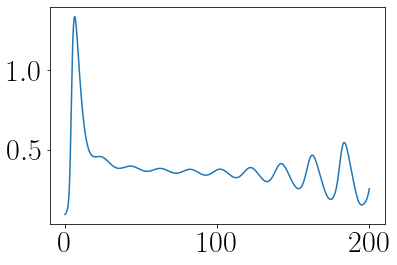

In [5]:
cfg.input_max = 0.135
run_Gstar_controlled_experiment('pulse', t_f=200, )
plt.plot(cfg.t, cfg.c)

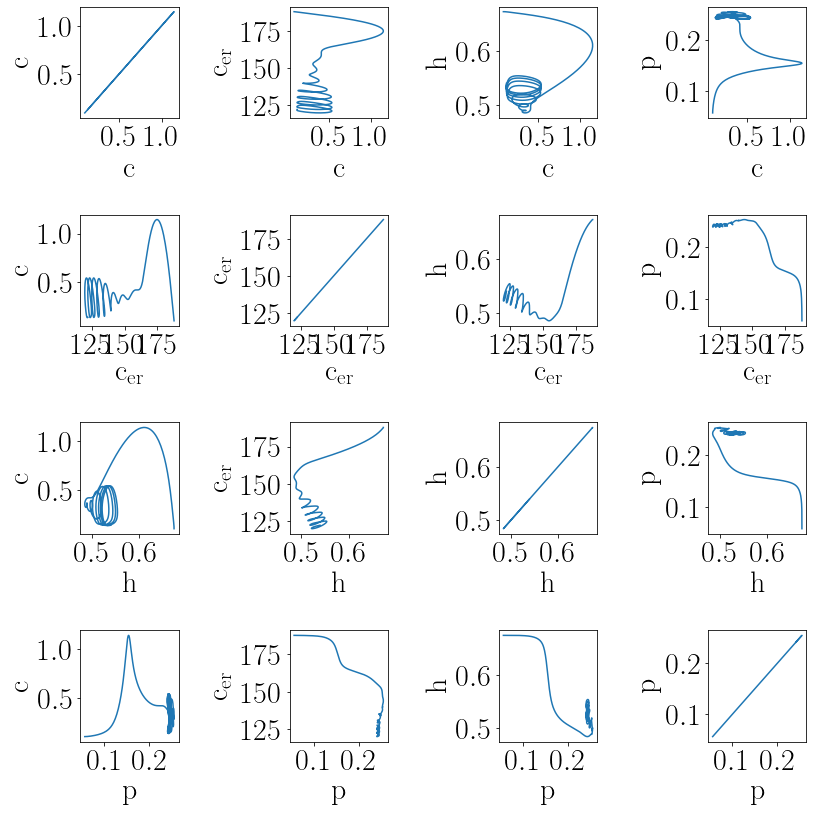

In [31]:
plot_vars = ['c', 'c_er', 'h', 'p']
labels = ['c', 'c$_\mathrm{er}$', 'h', 'p']
l = len(plot_vars)
fig, ax = plt.subplots(l, l, figsize=(l*3, l*3))

for i in range(l):
    for j in range(l):
        x = getattr(cfg, plot_vars[i])
        y = getattr(cfg, plot_vars[j])
        ax[i, j].plot(x, y)
        
        ax[i, j].set_xlabel(labels[i])
        ax[i, j].set_ylabel(labels[j])
        
plt.tight_layout()

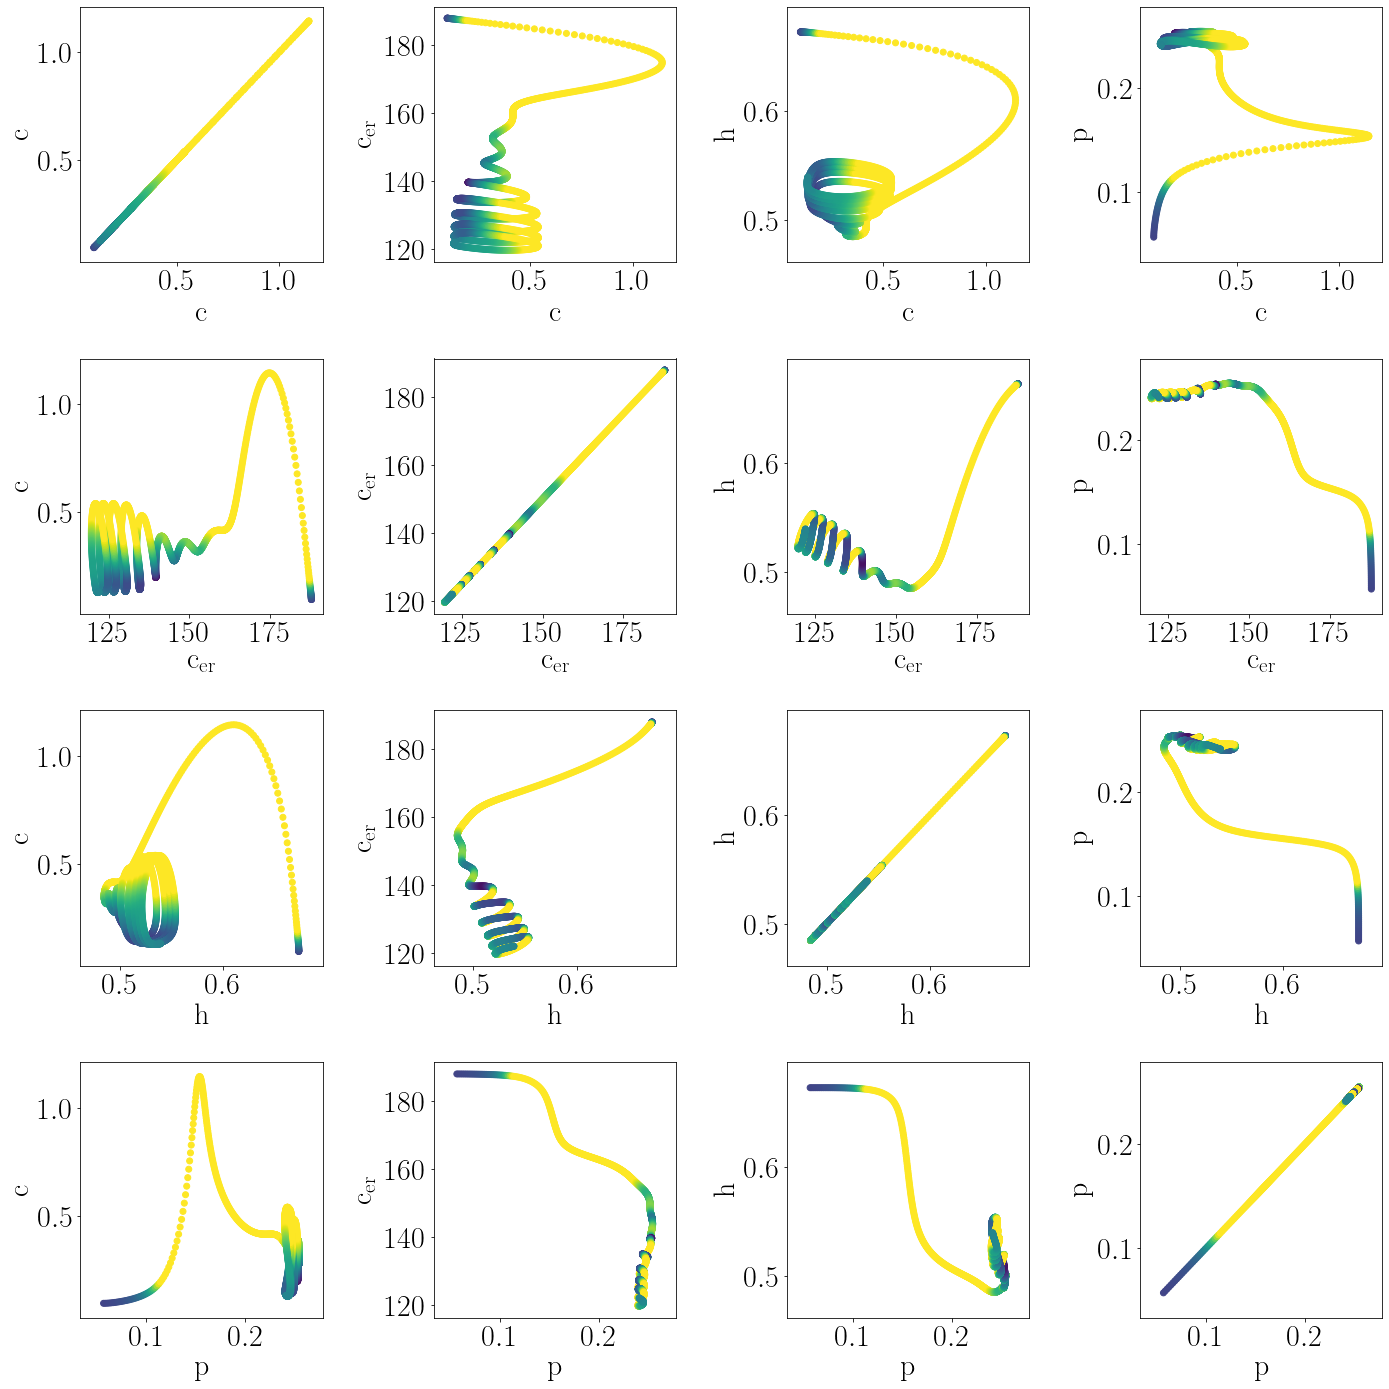

In [59]:
plot_vars = ['c', 'c_er', 'h', 'p']
labels = ['c', 'c$_\mathrm{er}$', 'h', 'p']
l = len(plot_vars)
fig, ax = plt.subplots(l, l, figsize=(l*5, l*5))

for i in range(l):
    for j in range(l):
        x = getattr(cfg, plot_vars[i])
        y = getattr(cfg, plot_vars[j])
        ax[i, j].scatter(x, y, c=l2_speeds, vmin=0, vmax=0.1)
        ax[i, j].set_xlabel(labels[i])
        ax[i, j].set_ylabel(labels[j])
        
plt.tight_layout()

In [56]:
ax[0, 0].

AttributeError: 'AxesSubplot' object has no attribute 'clim'

In [ ]:

ip3_ca_ode_equations(0, )

In [36]:
np.linalg.norm(dx)

0.045142664044038015

In [40]:
from matplotlib import cm

In [41]:
cm.viridis

In [72]:
l2_speeds = []
labels = ['c speed', 'c$_t$ speed', 'h speed', 'p speed']
speeds = [[], [], [], []]


for i in range(len(cfg.t)):
    x = np.array([cfg.c[i], cfg.c_tot[i], cfg.h[i], cfg.p[i]])
    dx = ip3_ca_ode_equations(0, x, Gstar=cfg.input_max)
    l2_speeds.append(np.linalg.norm(dx))
    
    for j in range(len(labels)):
#         h_speeds.append(np.abs(dx[2]))
#         c_t_speeds.append(np.abs(dx[1]))
        speeds[j].append(np.abs(dx[j]))

In [76]:
np.max(speeds[3])

0.02004370589940091

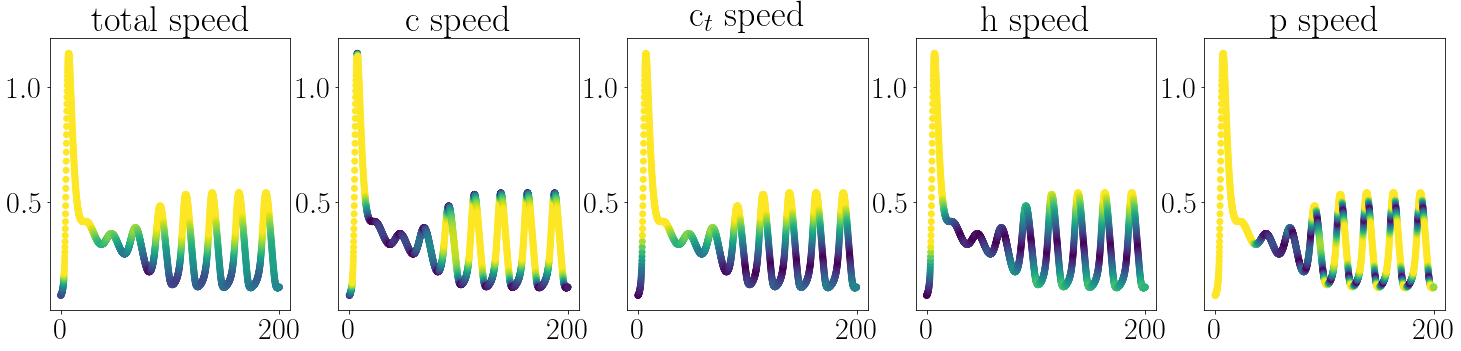

In [79]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

ax[0].scatter(cfg.t, cfg.c, c=l2_speeds, cmap='viridis', vmin=0, vmax=0.1)
ax[0].set_title('total speed')

vmaxes = [0.05, 0.1, 0.005, 0.001]

for j in range(len(labels)):
    ax[j+1].scatter(cfg.t, cfg.c, c=speeds[j], cmap='viridis', vmin=0, vmax=vmaxes[j])
    ax[j+1].set_title(labels[j])

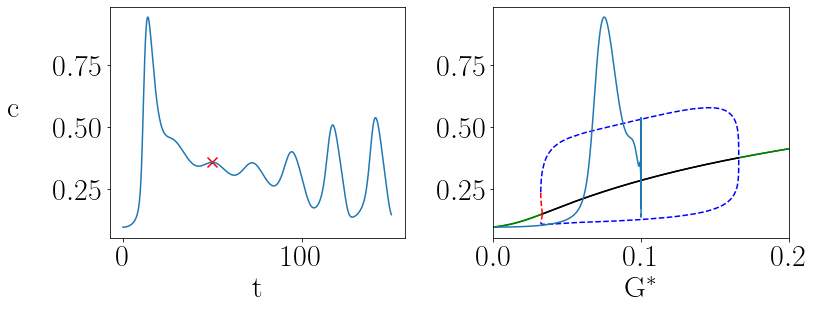

In [15]:
cfg.A = 0.1
cfg.d_rise = 150
cfg.r_rise = 0.1
cfg.d_decay = 30
cfg.r_decay = 0.1
x, y = get_input_plot('curve')
run_Gstar_controlled_experiment('curve', t_f=150)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(cfg.t, cfg.c)
ax[0].scatter(cfg.t[500], cfg.c[500], c='red', marker='x', s=100)
ax[0].set_xlabel('t')
ax[0].set_ylabel('c', rotation=0, labelpad=40)

plot_bifurcation('Gstar_bifurcation.dat')
Gstars = [curve_input(t) for t in cfg.t]
ax[1].plot(Gstars, cfg.c)
ax[1].set_xlim(0, 0.2)
ax[1].set_xlabel('G$^*$')
plt.tight_layout()
plt.savefig('figures/delay_plots/4_var_delay', bbox_inches='tight')

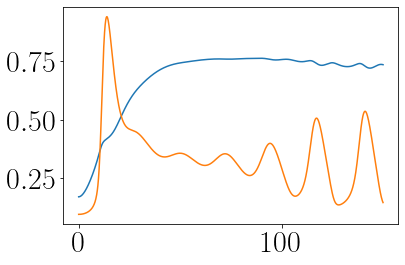

In [19]:
plt.plot(cfg.t, cfg.p * 3)
plt.plot(cfg.t, cfg.c)

In [21]:
all_init = cfg.all_init

In [22]:
cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]

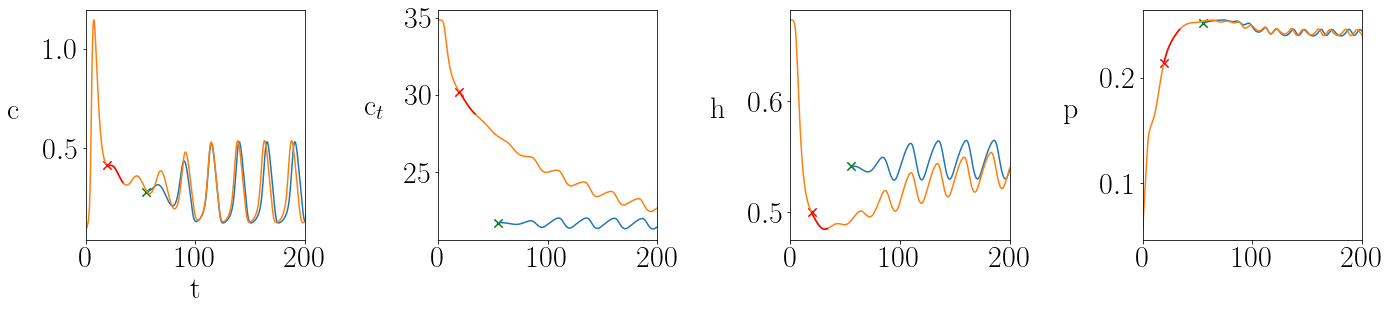

## Fix Gstar, c, see what speeds are for h, p, c_t

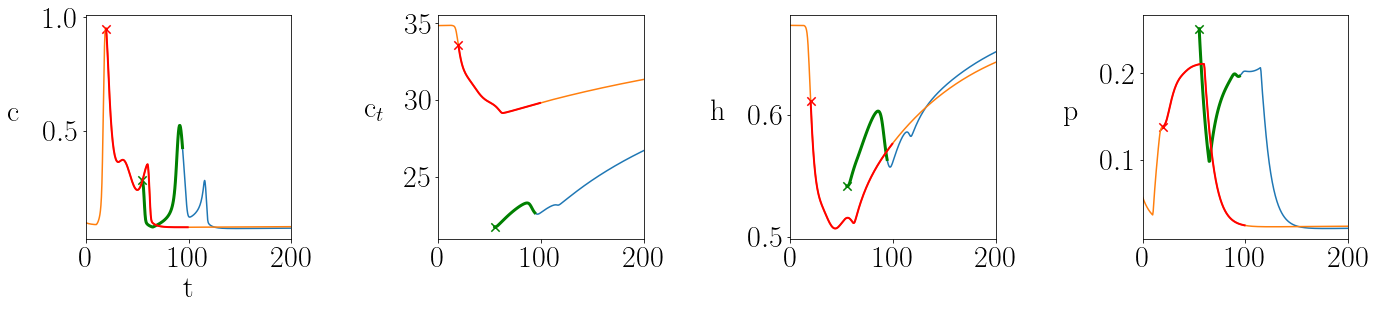

In [4]:
cfg.A = 0.1
cfg.d_rise = 150
cfg.r_rise = 0.1
cfg.d_decay = 30
cfg.r_decay = 0.1
# run_Gstar_controlled_experiment('curve', t_f=150)

cfg.input_max = 0.1
run_Gstar_controlled_experiment('pulse', t_f=150, max_step=0.5)


# fix_c = cfg.c[500]
# fix_h = cfg.h[500]
# fix_c_t = cfg.c_tot[500]
# fix_p = cfg.p[500]

starting_idx = 40
plot_len = 160 #plot length for plot starting at ss
plot_len_2 = 80 #plot length for plot starting at fp
ending_idx = starting_idx + plot_len
fix_c = cfg.c[starting_idx]
fix_h = cfg.h[starting_idx]
fix_c_t = cfg.c_tot[starting_idx]
fix_p = cfg.p[starting_idx]

fp_c = 0.28346
fp_h = 0.54148
fp_c_t = 21.7523
fp_p = 0.25122

spacing = 100

h_range = np.linspace(0.45, 0.7, spacing)
c_t_range = np.linspace(15, 35, spacing)
p_range = np.linspace(0.05, 0.4, spacing)
c_range = np.linspace(0.02, 0.7, spacing)


fixes = [fix_c, fix_c_t, fix_h, fix_p]
fps = [fp_c, fp_c_t, fp_h, fp_p]
ranges = [c_range, c_t_range, h_range, p_range]
labels = ['c', 'c$_t$', 'h', 'p']
var_names = ['c', 'c_tot', 'h', 'p']

starting_idx = 40
plot_len = 160
plot_len_2 = 80
endinx_idx = starting_idx + plot_len

cfg.input_max = 0.1

def plot_deriv_speed(speed, x_var, y_var, x_range=None, y_range=None, ax=None, Gstar=0.1, glutamate=False,
                    plot_from_fp=True, plot_from_exp=True, fix_idx=40, absolute=True, plot_labels=True):
    '''
    speed: variable to check speed of, can give label or idx
    x_var, y_var: the variables that will be plotted against, can give labels or idxs
    x_range, y_range: optionally pass in manual ranges to use
    ax: optionally pass an axis to plot on
    Gstar: whether we are working with Gstar inputs or glutamate inputs
    plot_from_fp: plot the start of fp
    plot_from_pulse: plot the a part of pulse exp
    fixes: index from which to start fixes from
    absolute: whether to give absolute speed
    '''
#     #set fixed data from bifurcation data
#     data = load_bifurcation_data('Gstar_bifurcation_all.dat')
#     #6 -> c vals
#     #7 -> c_tot vals
#     #8 -> h vals
#     #9 -> p vals
#     idx = np.argmax(data[3] >= Gstar)
#     fixes = [data[6][idx], data[7][idx], data[8][idx], data[9][idx]]
    
    cfg.input_max = Gstar
    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    fixes = [cfg.c[fix_idx], cfg.c_tot[fix_idx], cfg.h[fix_idx], cfg.p[fix_idx]]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
    X, Y = np.zeros((spacing, spacing)), np.zeros((spacing, spacing))
    speeds = np.zeros((spacing, spacing))
    
    if type(x_var) != type(0):
        x_var = var_names.index(x_var)
    if type(y_var) != type(0):
        y_var = var_names.index(y_var)
    if type(speed) != type(0):
        speed = var_names.index(speed)
        
    if x_range is None:
        x_range = ranges[x_var]
    if y_range is None:
        y_range = ranges[y_var]
        
#     print(y_range)
        
    #set the fixed inputs
    x_input = [0, 0, 0, 0]
    for i in range(len(var_names)):
        if i == x_var or i == y_var:
            continue
        else:
            x_input[i] = fixes[i]
    
    
    for i in range(spacing):
        for j in range(spacing):
                        
            x_input[x_var] = x_range[j]
            x_input[y_var] = y_range[i]
            X[i, j] = x_range[j]
            Y[i, j] = y_range[i]
            
            if Gstar:
                dx = ip3_ca_ode_equations(0, x_input, Gstar=Gstar)
                
#             if j == test:
#                 print(x_input)
#                 print(np.abs(dx[speed]))
            
            if absolute:
                speeds[i, j] = np.abs(dx[speed])
            else:
                speeds[i, j] = dx[speed]
    extent = [np.min(x_range), np.max(x_range), np.min(y_range), np.max(y_range)]
    ax.imshow(np.flip(speeds, axis=0), extent=extent, aspect='auto')
    
    if plot_labels:
        ax.set_xlabel(labels[x_var])
        ax.set_ylabel(labels[y_var], rotation=0, labelpad=30)
    
    if plot_from_fp:
        cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
        run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
        for i in range(5):
            ax.scatter(fps[x_var], fps[y_var], c='green', marker='x', s=100)
            ax.plot(getattr(cfg, var_names[x_var])[:plot_len_2], getattr(cfg, var_names[y_var])[:plot_len_2], c='green')
        cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
    
    if plot_from_exp:
        cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
        run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
        for i in range(5):
            ax.scatter(fixes[x_var], fixes[y_var], c='red', marker='x', s=100)
            ax.plot(getattr(cfg, var_names[x_var])[starting_idx:ending_idx], 
                       getattr(cfg, var_names[y_var])[starting_idx:ending_idx], c='red')
    return X, Y, speeds, x_range, y_range, extent
#     return y_range


def plot_deriv_quiver(x_var, y_var, plot_from_exp=True, fix_idx=40, Gstar=0.1, ax=None,
                     x_range=None, y_range=None):
    cfg.input_max = Gstar
    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    fixes = [cfg.c[fix_idx], cfg.c_tot[fix_idx], cfg.h[fix_idx], cfg.p[fix_idx]]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if type(x_var) != type(0):
        x_var = var_names.index(x_var)
    if type(y_var) != type(0):
        y_var = var_names.index(y_var)
        
    if x_range is None:
        x_range = ranges[x_var]
    if y_range is None:
        y_range = ranges[y_var]

    arrow_spacing = 10
    x_range = np.linspace(np.min(x_range), np.max(x_range), arrow_spacing)
    y_range = np.linspace(np.min(y_range), np.max(y_range), arrow_spacing)
    U = []
    V = []
    X = []
    Y = []

    #set the fixed inputs
    x_input = [0, 0, 0, 0]
    for i in range(len(var_names)):
        if i == x_var or i == y_var:
            continue
        else:
            x_input[i] = fixes[i]

    for i in range(arrow_spacing):
        for j in range(arrow_spacing):
            x = x_range[i]
            y = y_range[j]
            X.append(x)
            Y.append(y)
            x_input[2] = x
            x_input[3] = y

            dx = ip3_ca_ode_equations(0, x_input, Gstar=Gstar)

            U.append(dx[2])
            V.append(dx[3])

    # C = np.linalg.norm(np.array([arrows_h, arrows_p]), axis=0)
    C = np.hypot(U, V)
    ax.quiver(X, Y, U, V, C)
    
    if plot_from_exp:
        cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
        run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
        for i in range(5):
            ax.scatter(fixes[x_var], fixes[y_var], c='red', marker='x', s=100)
            ax.plot(getattr(cfg, var_names[x_var])[starting_idx:ending_idx], 
                       getattr(cfg, var_names[y_var])[starting_idx:ending_idx], c='red')


def run_Gstar_kick_experiment(kick_var='p', kick_val=0.01, kick_t=30, t_total=200, max_step=0.5):
    '''
    Perform a kick experiment using Gstar controlled
    '''
    run_Gstar_controlled_experiment('pulse', t_f=kick_t, max_step=max_step)
    getattr(cfg, kick_var)[-1] += kick_val
    continue_Gstar_controlled_experiment('pulse', t_cont=t_total-kick_t, max_step=max_step)


variables = ['c', 'c_tot', 'h', 'p']
labels = ['c', 'c$_t$', 'h', 'p']
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(4):
    ax[i].plot(cfg.t + 55, getattr(cfg, variables[i]))
    ax[i].scatter(cfg.t[0]+55, getattr(cfg, variables[i])[0], marker='x', c='green', s=70)
    ax[i].plot(cfg.t[:plot_len_2]+55, getattr(cfg, variables[i])[:plot_len_2], c='green', linewidth=3)
    
cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(4):
    ax[i].plot(cfg.t, getattr(cfg, variables[i]))
    ax[i].scatter(cfg.t[40], getattr(cfg, variables[i])[40], marker='x', c='red', s=70)
    ax[i].plot(cfg.t[starting_idx:ending_idx], getattr(cfg, variables[i])[starting_idx:ending_idx], c='red', linewidth=2)
ax[0].set_xlabel('t')
for i in range(4):
    ax[i].set_xlim([0, 200])
    ax[i].set_ylabel(labels[i], rotation=0, labelpad=30)
plt.tight_layout()

plt.savefig('figures/delay_plots/4_var_fp_versus_ss')


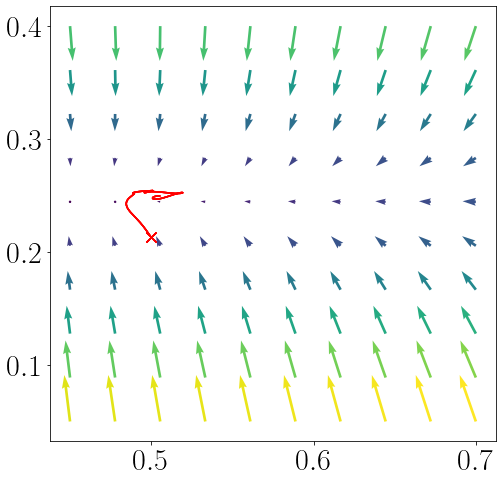

In [84]:
plot_deriv_quiver('h', 'p')

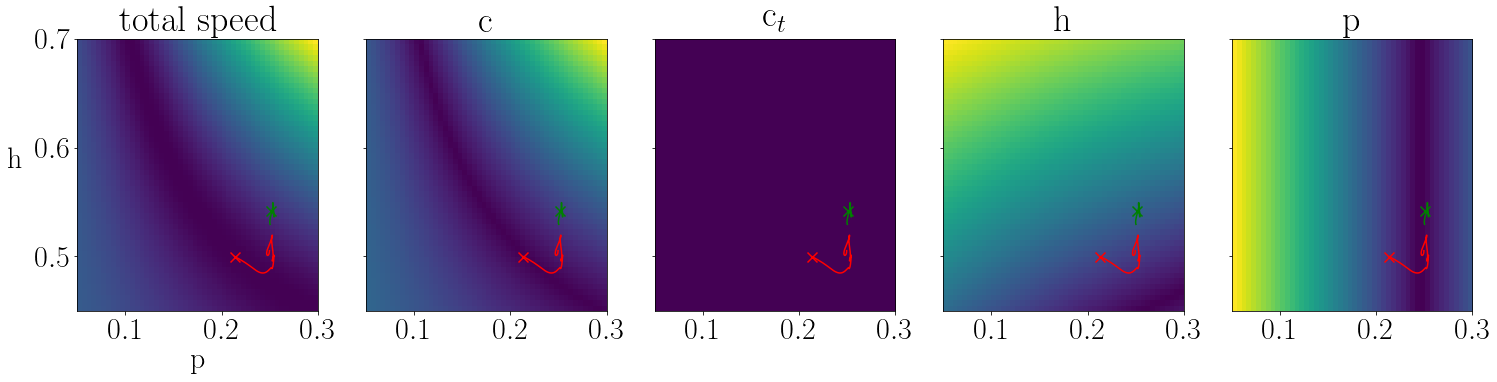

In [13]:
h_p_dx = np.zeros((spacing, spacing))
h_p_speeds = [np.zeros((spacing, spacing)), np.zeros((spacing, spacing)), 
              np.zeros((spacing, spacing)), np.zeros((spacing, spacing))]

h_X = np.zeros((spacing, spacing))
p_X = np.zeros((spacing, spacing))
for i in range(spacing):
    for j in range(spacing):
        x = np.array([fix_c, fix_c_t, h_range[i], p_range[j]])
        dx = ip3_ca_ode_equations(0, x, Gstar=0.1)
        h_p_dx[i, j] = np.linalg.norm(dx)
        
        h_X[i, j] = h_range[i]
        p_X[i, j] = p_range[j]
        
        for k in range(4):
            h_p_speeds[k][i, j] = np.abs(dx[k])
#         print(dx[1])
        
        
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

extent = [np.min(p_range), np.max(p_range), np.min(h_range), np.max(h_range)]
ax[0].imshow(np.flip(h_p_dx, axis=0), extent=extent, aspect='auto')
ax[0].set_title('total speed')

for k in range(4):
    ax[k+1].imshow(np.flip(h_p_speeds[k], axis=0), extent=extent, aspect='auto')
    ax[k+1].set_title(labels[k])

ax[0].set_xlabel('p')
ax[0].set_ylabel('h', rotation=0, labelpad=20)


#plot fp start
cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(5):
    ax[i].scatter(fp_p, fp_h, c='green', marker='x', s=100)
    ax[i].plot(cfg.p[:plot_len_2], cfg.h[:plot_len_2], c='green')
    

#plot ss start
cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(5):
    ax[i].scatter(fix_p, fix_h, c='red', marker='x', s=100)
    ax[i].plot(cfg.p[starting_idx:ending_idx], cfg.h[starting_idx:ending_idx], c='red')
    
# plt.savefig()

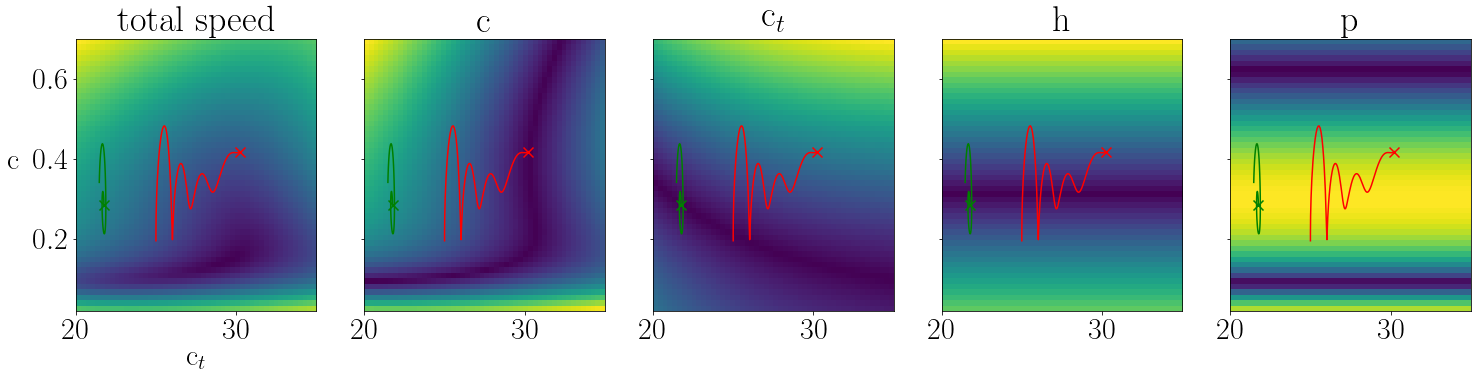

In [14]:
c_ct_dx = np.zeros((spacing, spacing))
c_ct_speeds = [np.zeros((spacing, spacing)), np.zeros((spacing, spacing)), 
              np.zeros((spacing, spacing)), np.zeros((spacing, spacing))]

c_X = np.zeros((spacing, spacing))
c_t_X = np.zeros((spacing, spacing))
for i in range(spacing):
    for j in range(spacing):
        x = np.array([c_range[i], c_t_range[j], fix_h, fix_p])
        dx = ip3_ca_ode_equations(0, x, Gstar=0.1)
        c_ct_dx[i, j] = np.linalg.norm(dx)
        
        c_X[i, j] = c_range[i]
        c_t_X[i, j] = c_t_range[j]
        
        for k in range(4):
            c_ct_speeds[k][i, j] = np.abs(dx[k])
#         print(dx[1])
        
        
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

extent = [np.min(c_t_range), np.max(c_t_range), np.min(c_range), np.max(c_range)]
ax[0].imshow(np.flip(c_ct_dx, axis=0), extent=extent, aspect='auto')
ax[0].set_title('total speed')

for k in range(4):
    ax[k+1].imshow(np.flip(c_ct_speeds[k], axis=0), extent=extent, aspect='auto')
    ax[k+1].set_title(labels[k])

ax[0].set_xlabel('c$_t$')
ax[0].set_ylabel('c', rotation=0, labelpad=20)
    
    
#plot fp start
cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(5):
    ax[i].scatter(fp_c_t, fp_c, c='green', marker='x', s=100)
    ax[i].plot(cfg.c_tot[:plot_len_2], cfg.c[:plot_len_2], c='green')
    

#plot ss start
cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(5):
    ax[i].scatter(fix_c_t, fix_c, c='red', marker='x', s=100)
    ax[i].plot(cfg.c_tot[starting_idx:ending_idx], cfg.c[starting_idx:ending_idx], c='red')
    

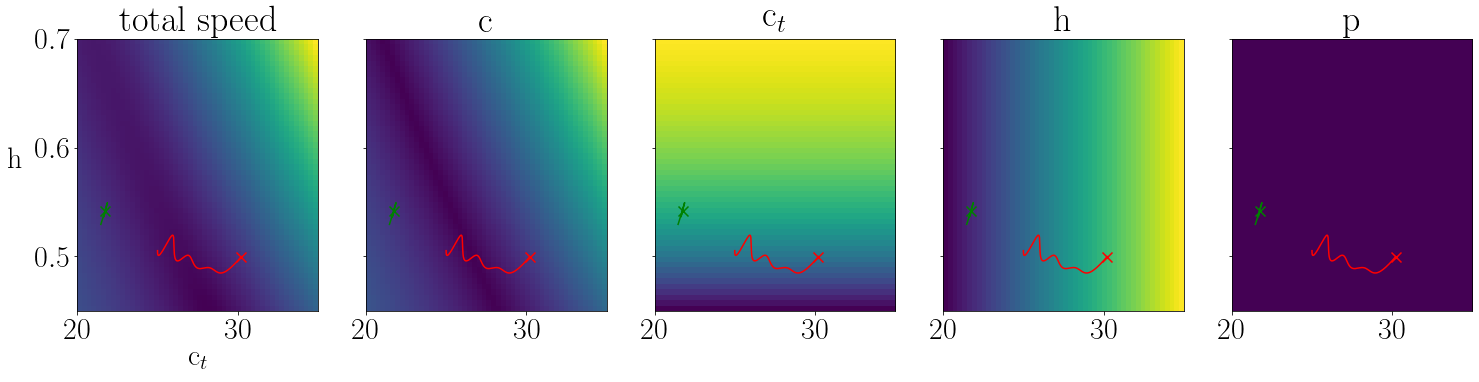

In [15]:
h_ct_dx = np.zeros((spacing, spacing))
h_ct_speeds = [np.zeros((spacing, spacing)), np.zeros((spacing, spacing)), 
              np.zeros((spacing, spacing)), np.zeros((spacing, spacing))]

h_X = np.zeros((spacing, spacing))
c_t_X = np.zeros((spacing, spacing))
for i in range(spacing):
    for j in range(spacing):
        x = np.array([fix_c, c_t_range[i], h_range[j], fix_p])
        dx = ip3_ca_ode_equations(0, x, Gstar=0.1)
        h_ct_dx[i, j] = np.linalg.norm(dx)
        
        h_X[i, j] = h_range[i]
        c_t_X[i, j] = c_t_range[j]
        
        for k in range(4):
            h_ct_speeds[k][i, j] = np.abs(dx[k])
#         print(dx[1])
        
        
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

extent = [np.min(c_t_range), np.max(c_t_range), np.min(h_range), np.max(h_range)]
ax[0].imshow(np.flip(h_ct_dx, axis=0), extent=extent, aspect='auto')
ax[0].set_title('total speed')

for k in range(4):
    ax[k+1].imshow(np.flip(h_ct_speeds[k], axis=0), extent=extent, aspect='auto')
    ax[k+1].set_title(labels[k])

ax[0].set_xlabel('c$_t$')
ax[0].set_ylabel('h', rotation=0, labelpad=20)
    
#plot fp start
cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(5):
    ax[i].scatter(fp_c_t, fp_h, c='green', marker='x', s=100)
    ax[i].plot(cfg.c_tot[:plot_len_2], cfg.h[:plot_len_2], c='green')
    

#plot ss start
cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(5):
    ax[i].scatter(fix_c_t, fix_h, c='red', marker='x', s=100)
    ax[i].plot(cfg.c_tot[starting_idx:ending_idx], cfg.h[starting_idx:ending_idx], c='red')
    

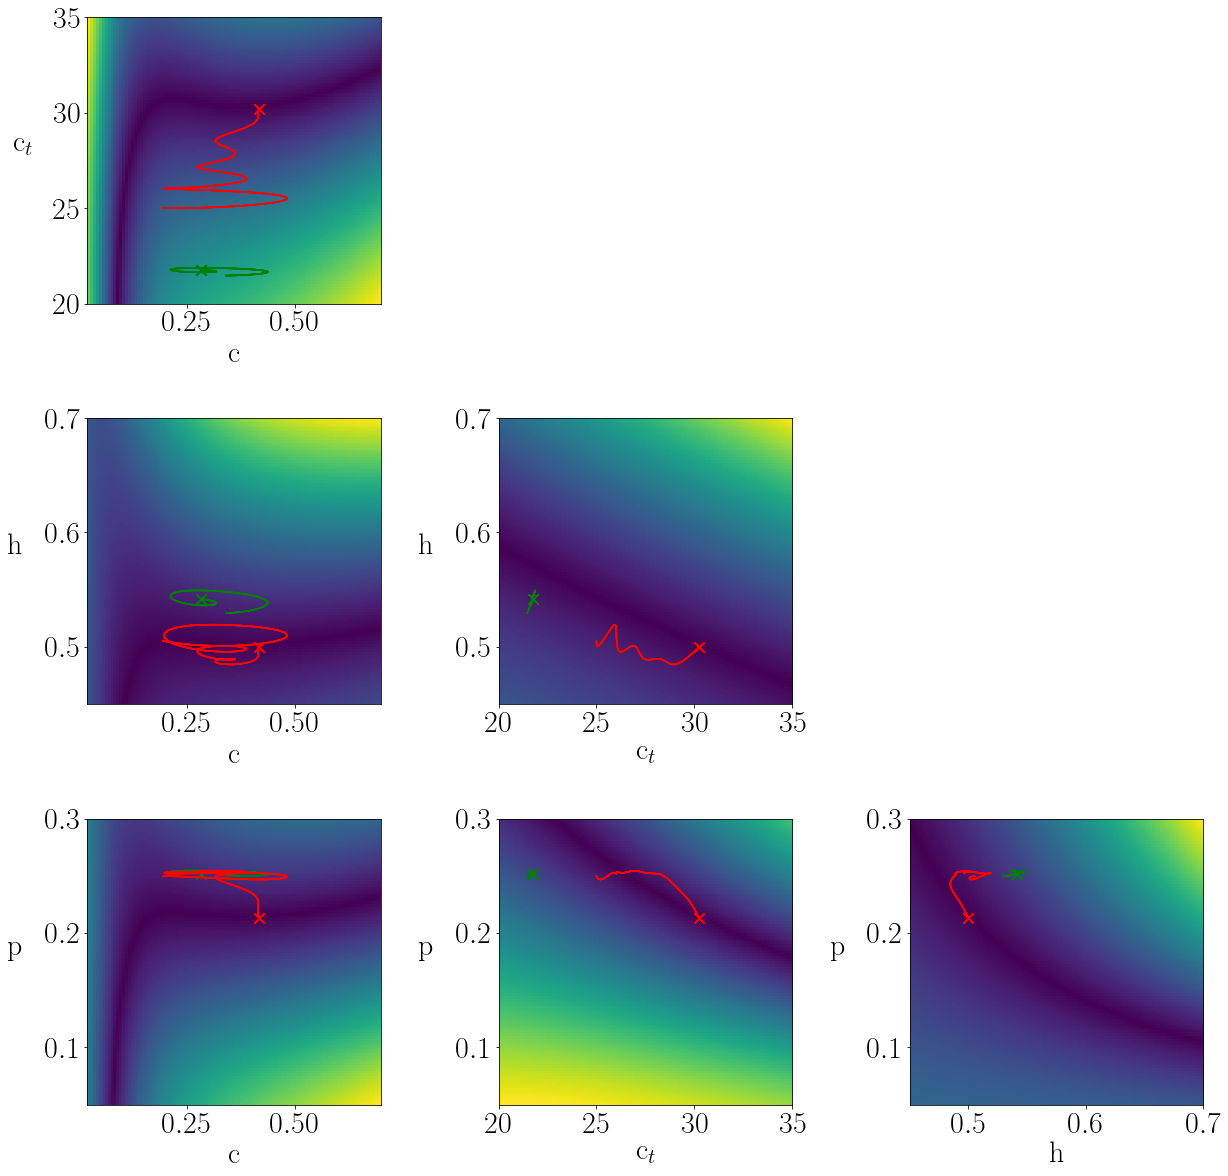

In [120]:
fig = plt.figure(constrained_layout=False, figsize=(20,20))
gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.4, hspace=0.4)

fixes = [fix_c, fix_c_t, fix_h, fix_p]
fps = [fp_c, fp_c_t, fp_h, fp_p]
ranges = [c_range, c_t_range, h_range, p_range]
labels = ['c', 'c$_t$', 'h', 'p']
var_names = ['c', 'c_tot', 'h', 'p']

#which vars to plot together
plot_vars = [[0, 1], None, None, [0, 2], [1, 2], None, [0, 3], [1, 3], [2, 3]]
fix_vars = [[2, 3], None, None, [1, 3], [0, 3], None, [1, 2], [0, 2], [0, 1]]

for t in range(len(plot_vars)):
    m = int(np.floor(t / 3))
    n = int(t % 3)
    vs = plot_vars[t] #gives indices for variables that are variable
    fix_vs = fix_vars[t] #gives indices for variables that are fixed

    if vs == None:
        continue
    ax = fig.add_subplot(gs[m, n])
    
    x_range = ranges[vs[0]]
    y_range = ranges[vs[1]]
    X, Y = np.zeros((spacing, spacing)), np.zeros((spacing, spacing))
    c_speeds = np.zeros((spacing, spacing))
    
    for i in range(spacing):
        for j in range(spacing):
            x_input = [0, 0, 0, 0]
            x = x_range[j]
            y = y_range[i]
            x_input[vs[0]] = x
            x_input[vs[1]] = y
            for v in fix_vs:
                x_input[v] = fixes[v]
            
            dx = ip3_ca_ode_equations(0, x_input, Gstar=0.1)
            
            X[i, j] = x
            Y[i, j] = y
            
            c_speeds[i, j] = np.abs(dx[0])
            
    extent = [np.min(x_range), np.max(x_range), np.min(y_range), np.max(y_range)]
    ax.imshow(np.flip(c_speeds, axis=0), extent=extent, aspect='auto')
    
    ax.set_xlabel(labels[vs[0]])
    ax.set_ylabel(labels[vs[1]], rotation=0, labelpad=30)
    
    
    v1 = var_names[vs[0]]
    v2 = var_names[vs[1]]
    #plot fp start    
    cfg.all_init = [fp_c, fp_c_t, fp_h, fp_p, 0, 0, 0, 0]
    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    for i in range(5):
        ax.scatter(fps[vs[0]], fps[vs[1]], c='green', marker='x', s=100)
        ax.plot(getattr(cfg, v1)[:plot_len_2], getattr(cfg, v2)[:plot_len_2], c='green')
    
    
    #plot ss start
    cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    for i in range(5):
        ax.scatter(fixes[vs[0]], fixes[vs[1]], c='red', marker='x', s=100)
        ax.plot(getattr(cfg, v1)[starting_idx:ending_idx], getattr(cfg, v2)[starting_idx:ending_idx], c='red')

plt.savefig('figures/delay_plots/4_var_c_speeds', bbox_inches='tight')

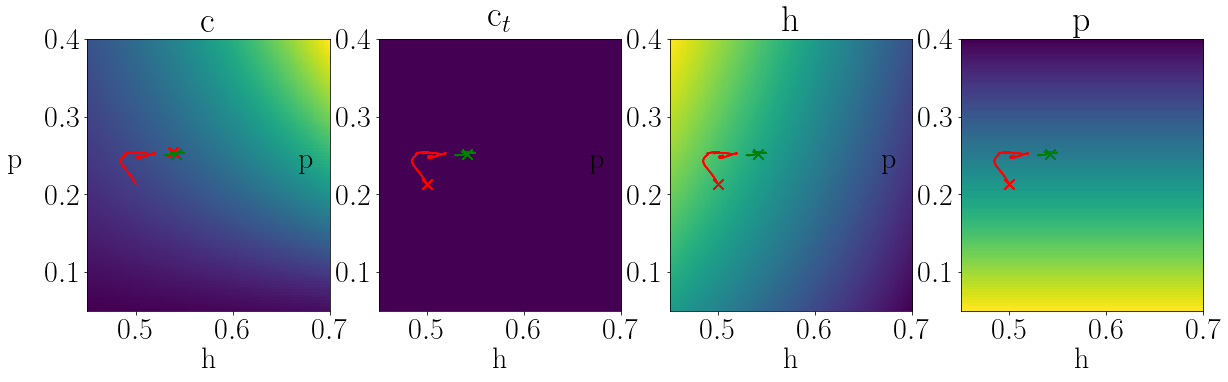

In [55]:
fig, ax = plt.subplots(1, len(var_names), figsize=(20, 5))
for i in range(len(var_names)):
    s = var_names[i]
    s1 = plot_deriv_speed(s, 'h', 'p', ax=ax[i], absolute=False)
    ax[i].set_title(labels[i])

In [61]:
len(X)

100

In [ ]:
np.hypot()

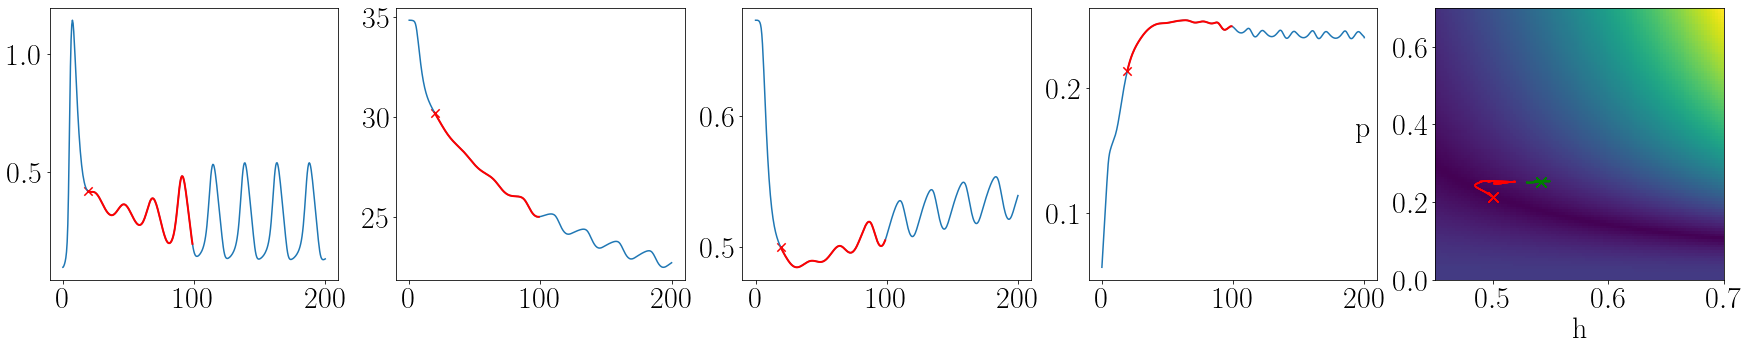

In [21]:
cfg.all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
fig, ax =plt.subplots(1, 5, figsize=(30, 5))

run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
plot_deriv_speed('c', 'h', 'p', ax=ax[4], y_range=np.linspace(0, 0.7, 100))

for i in range(4):
    ax[i].plot(cfg.t, getattr(cfg, variables[i]))
    ax[i].scatter(cfg.t[40], getattr(cfg, variables[i])[40], marker='x', c='red', s=70)
    ax[i].plot(cfg.t[starting_idx:ending_idx], getattr(cfg, variables[i])[starting_idx:ending_idx], c='red', linewidth=2)


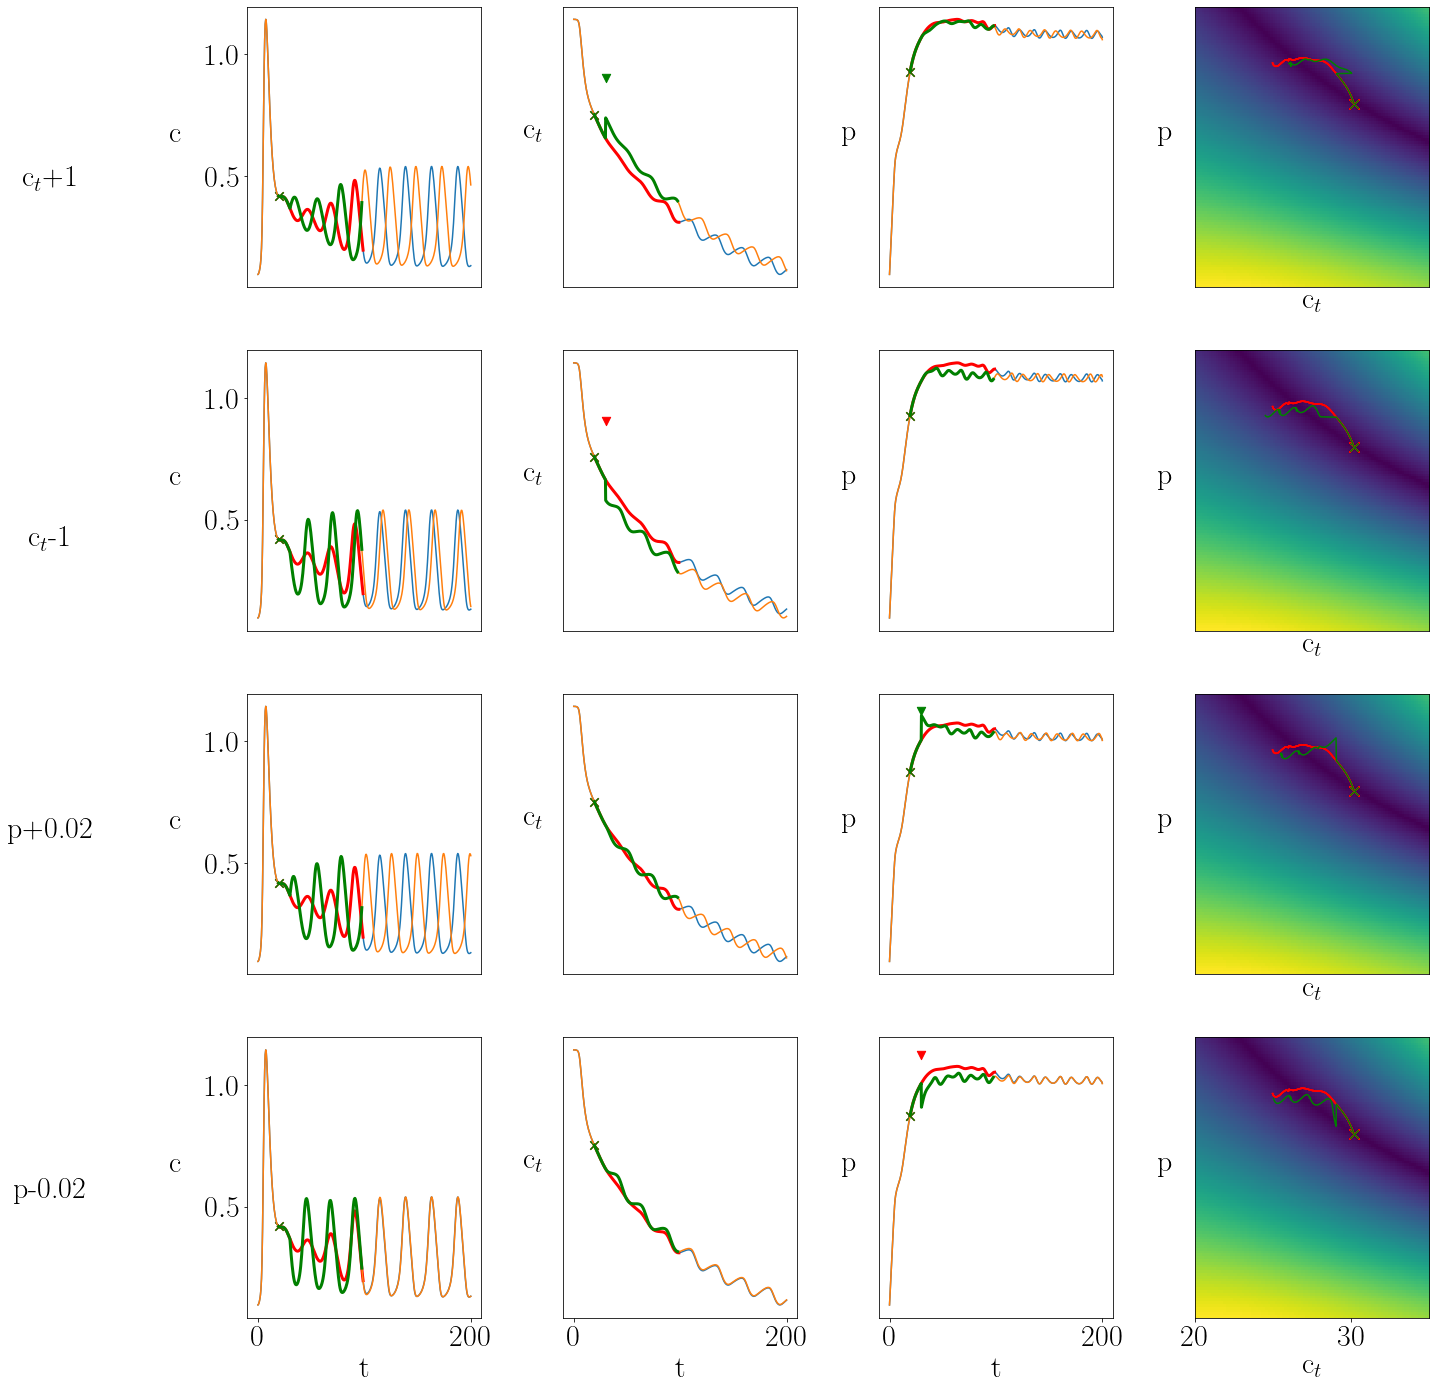

In [119]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
kicks = [['c_tot', 1], ['c_tot', -1], ['p', 0.02], ['p', -0.02]]
plot_vars = ['c', 'c_tot', 'p']
y_labels = ['c', 'c$_t$', 'p']
kick_labels = ['c$_t$+1', 'c$_t$-1', 'p+0.02', 'p-0.02']
text_pos = [0.85, 0.6, 0.4, 0.15]

run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(4):
    for j in range(3):
        y = getattr(cfg, plot_vars[j])
        ax[i, j].plot(cfg.t, y)
        ax[i, j].scatter(cfg.t[starting_idx], y[starting_idx], marker='x', s=70, c='red')
        ax[i, j].plot(cfg.t[starting_idx:ending_idx], y[starting_idx:ending_idx], c='red', linewidth=3)
    plot_deriv_speed('c', 'c_tot', 'p', ax=ax[i, 3], plot_from_fp=False)

for i in range(4):
    #perform kick experiment
    kick = kicks[i]
    
    run_Gstar_controlled_experiment('pulse', t_f=30, max_step=0.5)
    getattr(cfg, kick[0])[-1] += kick[1]
    continue_Gstar_controlled_experiment('pulse', t_cont=170, max_step=0.5)
    
    kick_idx = np.argmax(cfg.t >= 30)
    for j in range(3):
        y = getattr(cfg, plot_vars[j])
        ax[i, j].plot(cfg.t, y, label='c$_t$ kick')
        ax[i, j].scatter(cfg.t[starting_idx], y[starting_idx], marker='x', s=70, c='green')
        ax[i, j].plot(cfg.t[starting_idx:ending_idx], y[starting_idx:ending_idx], c='green', linewidth=3)
        
        if plot_vars.index(kick[0]) == j:
            if kick[1] > 0:
                c = 'green'
            else:
                c = 'red'
            ax[i, j].scatter(cfg.t[kick_idx], y[kick_idx-1] * 1.1, marker='v', s=70, c=c)
        
    ax[i, 3].scatter(cfg.c_tot[starting_idx], cfg.p[starting_idx], marker='x', s=70, c='green')
    ax[i, 3].plot(cfg.c_tot[starting_idx:ending_idx], cfg.p[starting_idx:ending_idx], c='green')
    
    
for i in range(4):
    for j in range(4):
        if i != 3:
            ax[i, j].set_xticks([])
        if j != 0:
            ax[i, j].set_yticks([])
        if j != 3:
            ax[i, j].set_ylabel(y_labels[j], rotation=0, labelpad=30)
        if i == 3 and j != 3:
            ax[i, j].set_xlabel('t')
        
        if j == 0:
            ax[i, j].text(0.02, text_pos[i], kick_labels[i], fontsize=30, ha='center', 
                transform=plt.gcf().transFigure)

plt.tight_layout()
plt.savefig('figures/delay_plots/4_var_kicks', bbox_inches='tight')


(0, 0.2)

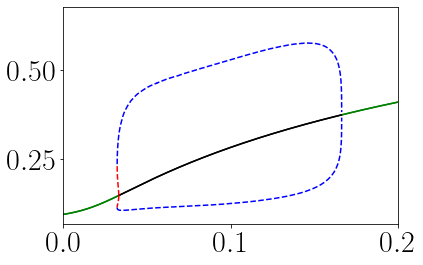

In [167]:
plot_bifurcation('Gstar_bifurcation.dat')
plt.xlim([0, 0.2])

In [168]:
fixes

[0.417959505569667,
 30.220411060927646,
 0.4997667198965037,
 0.21344923825515252]

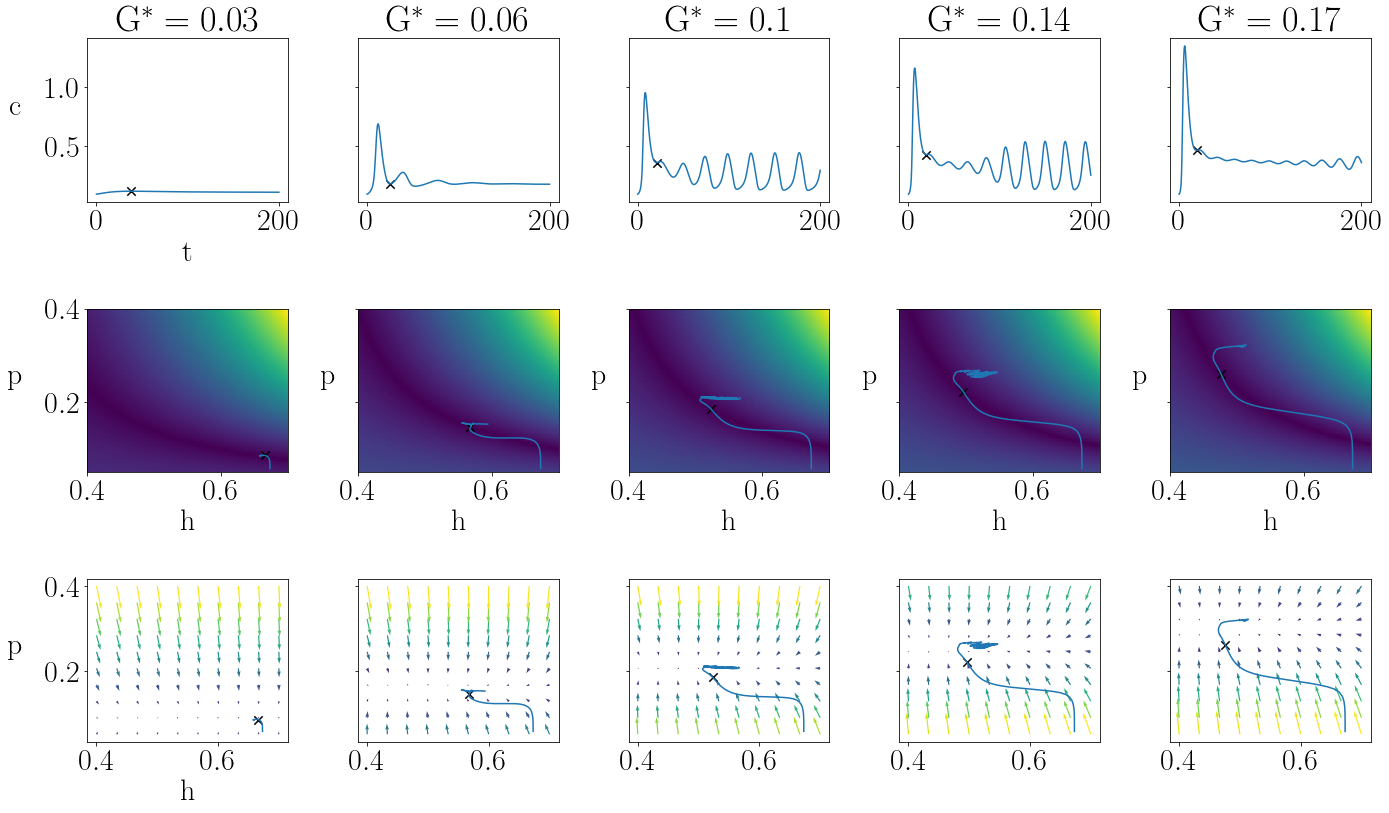

In [11]:
Gstars = np.linspace(0.03, 0.17, 5)
cfg.input_duration = 1000
cfg.input_start = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 12), sharey='row')
for i, Gstar in enumerate(Gstars):
    
    cfg.input_max = Gstar
    plot_deriv_speed('c', 'h', 'p', plot_from_fp=False, plot_from_exp=False, ax=ax[1, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    plot_deriv_quiver('h', 'p', plot_from_exp=False, ax=ax[2, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    

    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    end = end_first_response(cfg.t, cfg.c)
    
    ax[1, i].plot(cfg.h, cfg.p)
    ax[2, i].plot(cfg.h, cfg.p)
    ax[0, i].plot(cfg.t, cfg.c)

    if end:
        ax[1, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[2, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[0, i].scatter(cfg.t[end], cfg.c[end], marker='x', c='k', s=70)

    
    ax[0, i].set_title('G$^*=' + str(round(Gstar, 2)) + '$')
    
ax[0, 0].set_ylabel('c', rotation=0, labelpad=30)
ax[0, 0].set_xlabel('t')
ax[2, 0].set_xlabel('h')
ax[2, 0].set_ylabel('p', rotation=0, labelpad=30)
plt.tight_layout()
    
plt.savefig('figures/delay_plots/Gstar_slows', bbox_inches='tight')

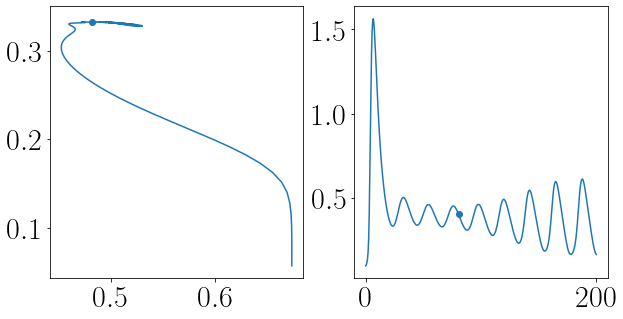

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(cfg.h, cfg.p)
idx = np.argmax(cfg.p)
ax[0].scatter(cfg.h[idx], cfg.p[idx])

ax[1].plot(cfg.t, cfg.c)
ax[1].scatter(cfg.t[idx], cfg.c[idx])

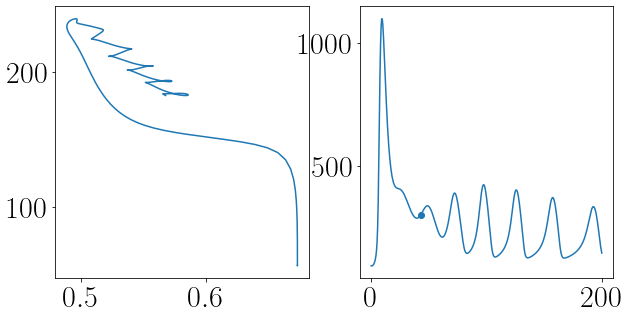

In [19]:
cfg.input_max = 0.07
run_experiment('pulse', t_f=200, max_step=0.5)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(cfg.h, cfg.p)
idx = np.argmax(cfg.p)
# ax[0].scatter(cfg.h[idx], cfg.p[idx])

ax[1].plot(cfg.t, cfg.c)
ax[1].scatter(cfg.t[idx], cfg.c[idx])

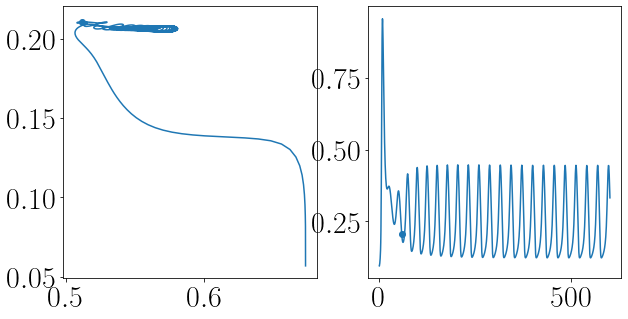

In [37]:
cfg.input_max = 0.1
run_Gstar_controlled_experiment('pulse', t_f=600, max_step=0.5)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(cfg.h, cfg.p)
idx = np.argmax(cfg.p)
ax[0].scatter(cfg.h[idx], cfg.p[idx])

ax[1].plot(cfg.t, cfg.c)
ax[1].scatter(cfg.t[idx], cfg.c[idx])

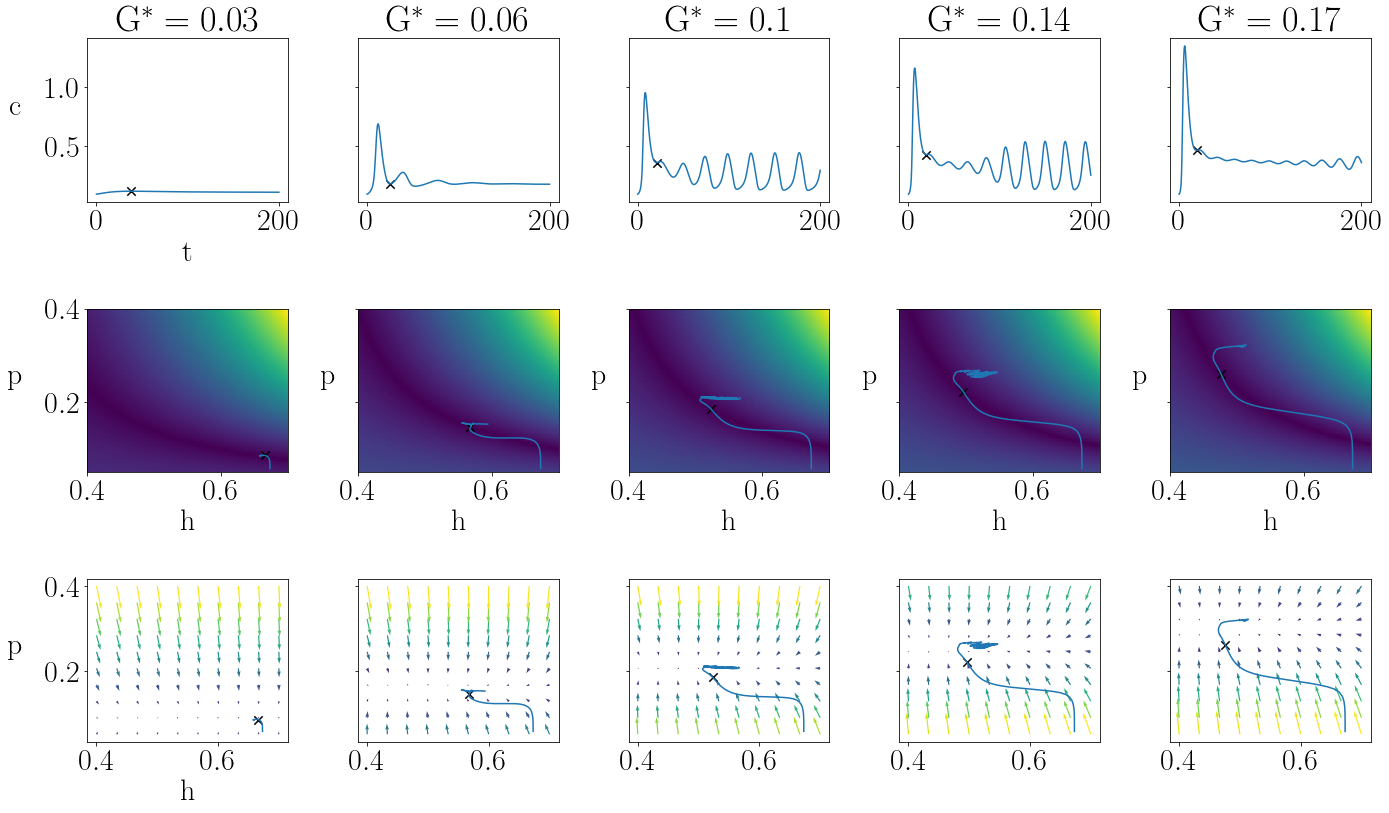

In [11]:
Gstars = np.linspace(0.03, 0.17, 5)
cfg.input_duration = 1000
cfg.input_start = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 12), sharey='row')
for i, Gstar in enumerate(Gstars):
    
    cfg.input_max = Gstar
    plot_deriv_speed('c', 'h', 'p', plot_from_fp=False, plot_from_exp=False, ax=ax[1, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    plot_deriv_quiver('h', 'p', plot_from_exp=False, ax=ax[2, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    

    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    end = end_first_response(cfg.t, cfg.c)
    
    ax[1, i].plot(cfg.h, cfg.p)
    ax[2, i].plot(cfg.h, cfg.p)
    ax[0, i].plot(cfg.t, cfg.c)

    if end:
        ax[1, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[2, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[0, i].scatter(cfg.t[end], cfg.c[end], marker='x', c='k', s=70)

    
    ax[0, i].set_title('G$^*=' + str(round(Gstar, 2)) + '$')
    
ax[0, 0].set_ylabel('c', rotation=0, labelpad=30)
ax[0, 0].set_xlabel('t')
ax[2, 0].set_xlabel('h')
ax[2, 0].set_ylabel('p', rotation=0, labelpad=30)
plt.tight_layout()
    
plt.savefig('figures/delay_plots/Gstar_slows', bbox_inches='tight')

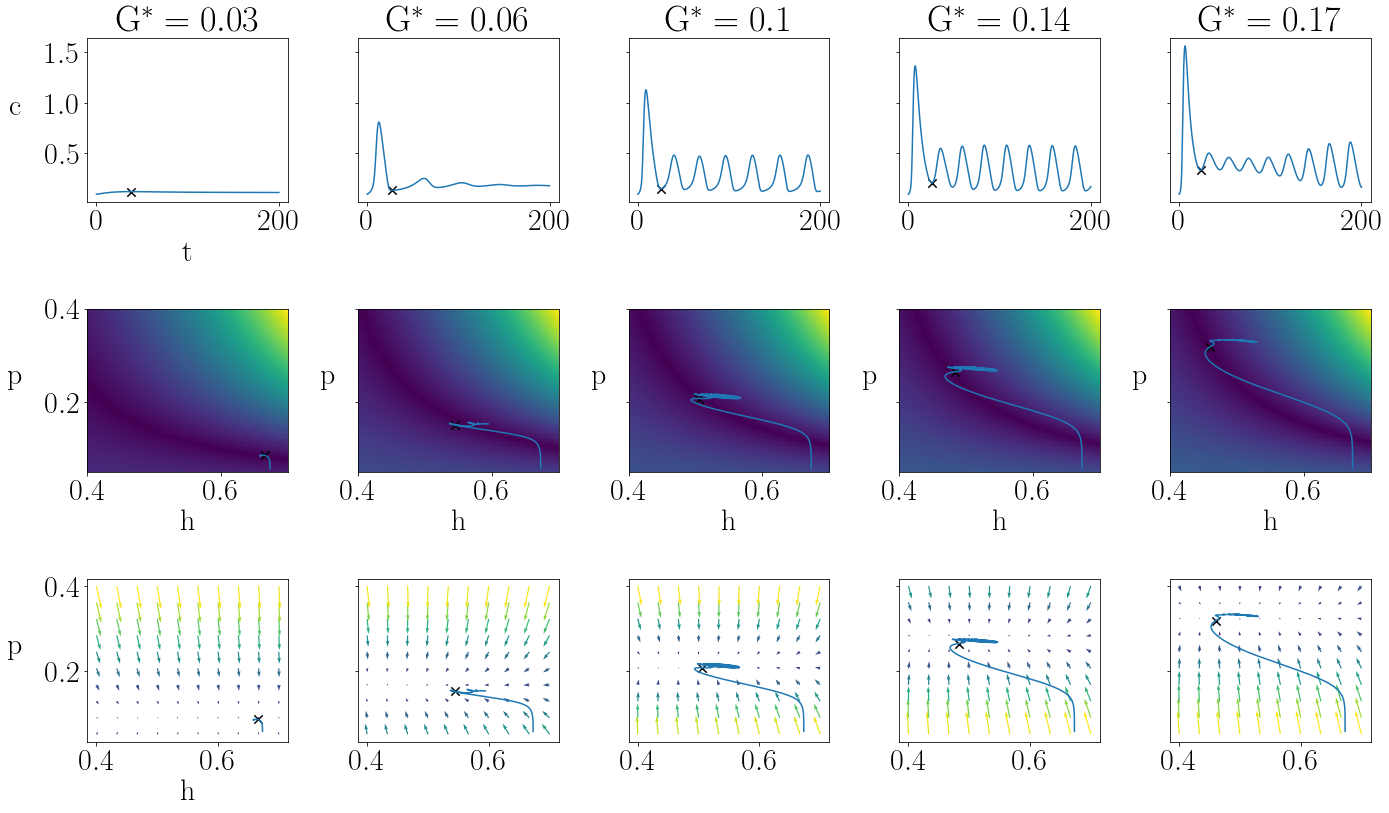

In [12]:
Gstars = np.linspace(0.03, 0.17, 5)
cfg.input_duration = 1000
cfg.input_start = 0
cfg.v_3k = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 12), sharey='row')
for i, Gstar in enumerate(Gstars):
    
    cfg.input_max = Gstar
    plot_deriv_speed('c', 'h', 'p', plot_from_fp=False, plot_from_exp=False, ax=ax[1, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    plot_deriv_quiver('h', 'p', plot_from_exp=False, ax=ax[2, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    

    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    end = end_first_response(cfg.t, cfg.c)
    
    ax[1, i].plot(cfg.h, cfg.p)
    ax[2, i].plot(cfg.h, cfg.p)
    ax[0, i].plot(cfg.t, cfg.c)

    if end:
        ax[1, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[2, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[0, i].scatter(cfg.t[end], cfg.c[end], marker='x', c='k', s=70)

    
    ax[0, i].set_title('G$^*=' + str(round(Gstar, 2)) + '$')
    
ax[0, 0].set_ylabel('c', rotation=0, labelpad=30)
ax[0, 0].set_xlabel('t')
ax[2, 0].set_xlabel('h')
ax[2, 0].set_ylabel('p', rotation=0, labelpad=30)
plt.tight_layout()
cfg.v_3k = 0.1
    
plt.savefig('figures/delay_plots/Gstar_slows2', bbox_inches='tight')

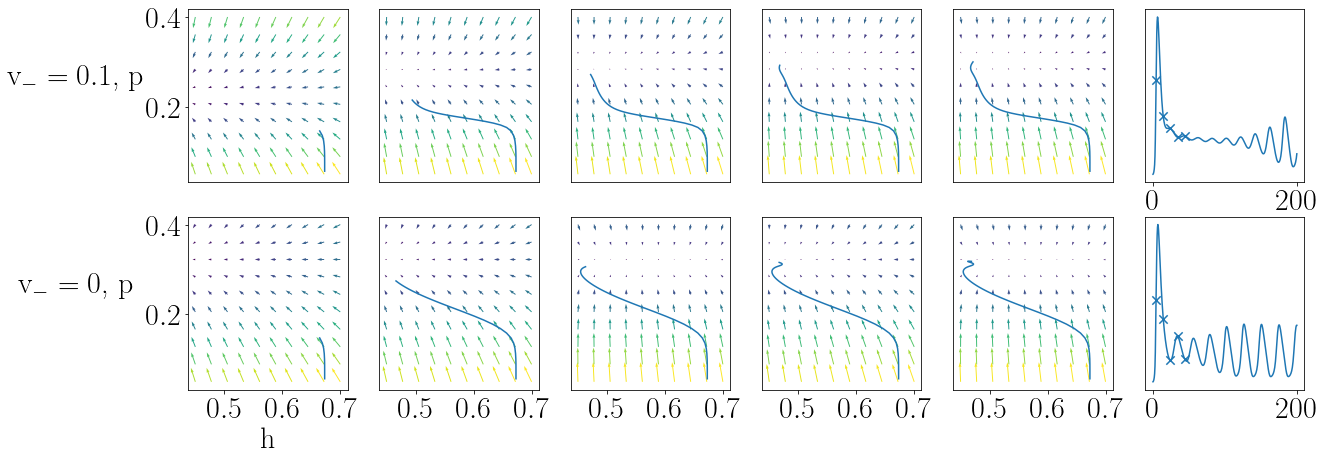

In [134]:
idxs = [10, 30, 50, 70, 90]
fig, ax = plt.subplots(2, 6, figsize=(20, 7))
Gstar = 0.135
cfg.input_max = Gstar
for i, idx in enumerate(idxs):
    cfg.v_3k = 0.1
    plot_deriv_quiver('h', 'p', plot_from_exp=False, ax=ax[0, i], fix_idx=idx, Gstar=Gstar)
    
    cfg.v_3k = 0
    plot_deriv_quiver('h', 'p', plot_from_exp=False, ax=ax[1, i], fix_idx=idx, Gstar=Gstar)
    
cfg.v_3k = 0.1
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i, idx in enumerate(idxs):
    ax[0, i].plot(cfg.h[:idx], cfg.p[:idx])
ax[0, 5].plot(cfg.t, cfg.c)
ax[0, 5].scatter(cfg.t[idxs], cfg.c[idxs], marker='x', s=70)

cfg.v_3k = 0
run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i, idx in enumerate(idxs):
    ax[1, i].plot(cfg.h[:idx], cfg.p[:idx])
ax[1, 5].plot(cfg.t, cfg.c)
ax[1, 5].scatter(cfg.t[idxs], cfg.c[idxs], marker='x', s=70)
    
cfg.v_3k = 0.1

ax[0, 0].set_ylabel('v$_-=0.1$, p', rotation=0, labelpad=70)
ax[1, 0].set_ylabel('v$_-=0$, p', rotation=0, labelpad=70)

for i in range(2):
    for j in range(6):
        if i == 0 and j > 0 and j < 5:
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        if i == 0 and j == 0:
            ax[i, j].set_xticks([])
        if i == 1 and j > 0 and j < 5:
            ax[i, j].set_yticks([])
        if j == 5:
            ax[i, j].set_yticks([])
            
ax[1, 0].set_xlabel('h')
# plt.tight_layout()
plt.savefig('figures/delay_plots/quiver_evolution', bbox_inches='tight')

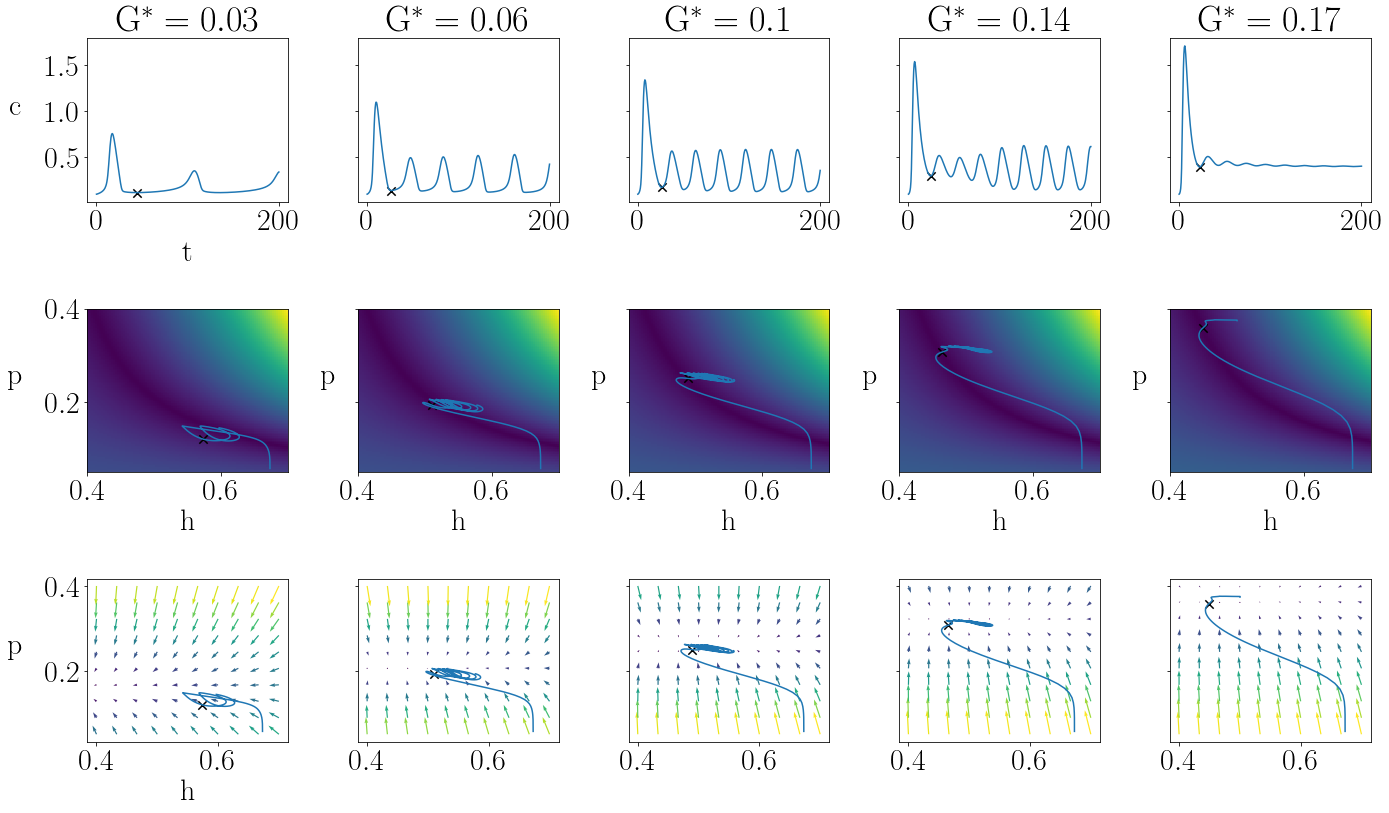

In [126]:
cfg.v_3k = 0
Gstars = np.linspace(0.03, 0.17, 5)
fig, ax = plt.subplots(3, 5, figsize=(20, 12), sharey='row')
for i, Gstar in enumerate(Gstars):
    
    cfg.input_max = Gstar
    plot_deriv_speed('c', 'h', 'p', plot_from_fp=False, plot_from_exp=False, ax=ax[1, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    plot_deriv_quiver('h', 'p', plot_from_exp=False, ax=ax[2, i], Gstar=Gstar, x_range=np.linspace(0.4, 0.7, 100))
    

    run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
    end = end_first_response(cfg.t, cfg.c)
    
    ax[1, i].plot(cfg.h, cfg.p)
    ax[2, i].plot(cfg.h, cfg.p)
    ax[0, i].plot(cfg.t, cfg.c)

    if end:
        ax[1, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[2, i].scatter(cfg.h[end], cfg.p[end], marker='x', c='k', s=70)
        ax[0, i].scatter(cfg.t[end], cfg.c[end], marker='x', c='k', s=70)

    
    ax[0, i].set_title('G$^*=' + str(round(Gstar, 2)) + '$')
    
ax[0, 0].set_ylabel('c', rotation=0, labelpad=30)
ax[0, 0].set_xlabel('t')
ax[2, 0].set_xlabel('h')
ax[2, 0].set_ylabel('p', rotation=0, labelpad=30)
plt.tight_layout()

cfg.v_3k = 0.1
    
plt.savefig('figures/delay_plots/Gstar_slows_v3k_0', bbox_inches='tight')

In [108]:
vis_dict

{'response_start_index': 6,
 'response_end_index': 402,
 'mp_peaks': [14, 107],
 'mp_troughs': [47],
 'end_first_response': None,
 'base_c': 0.09540940935343122}

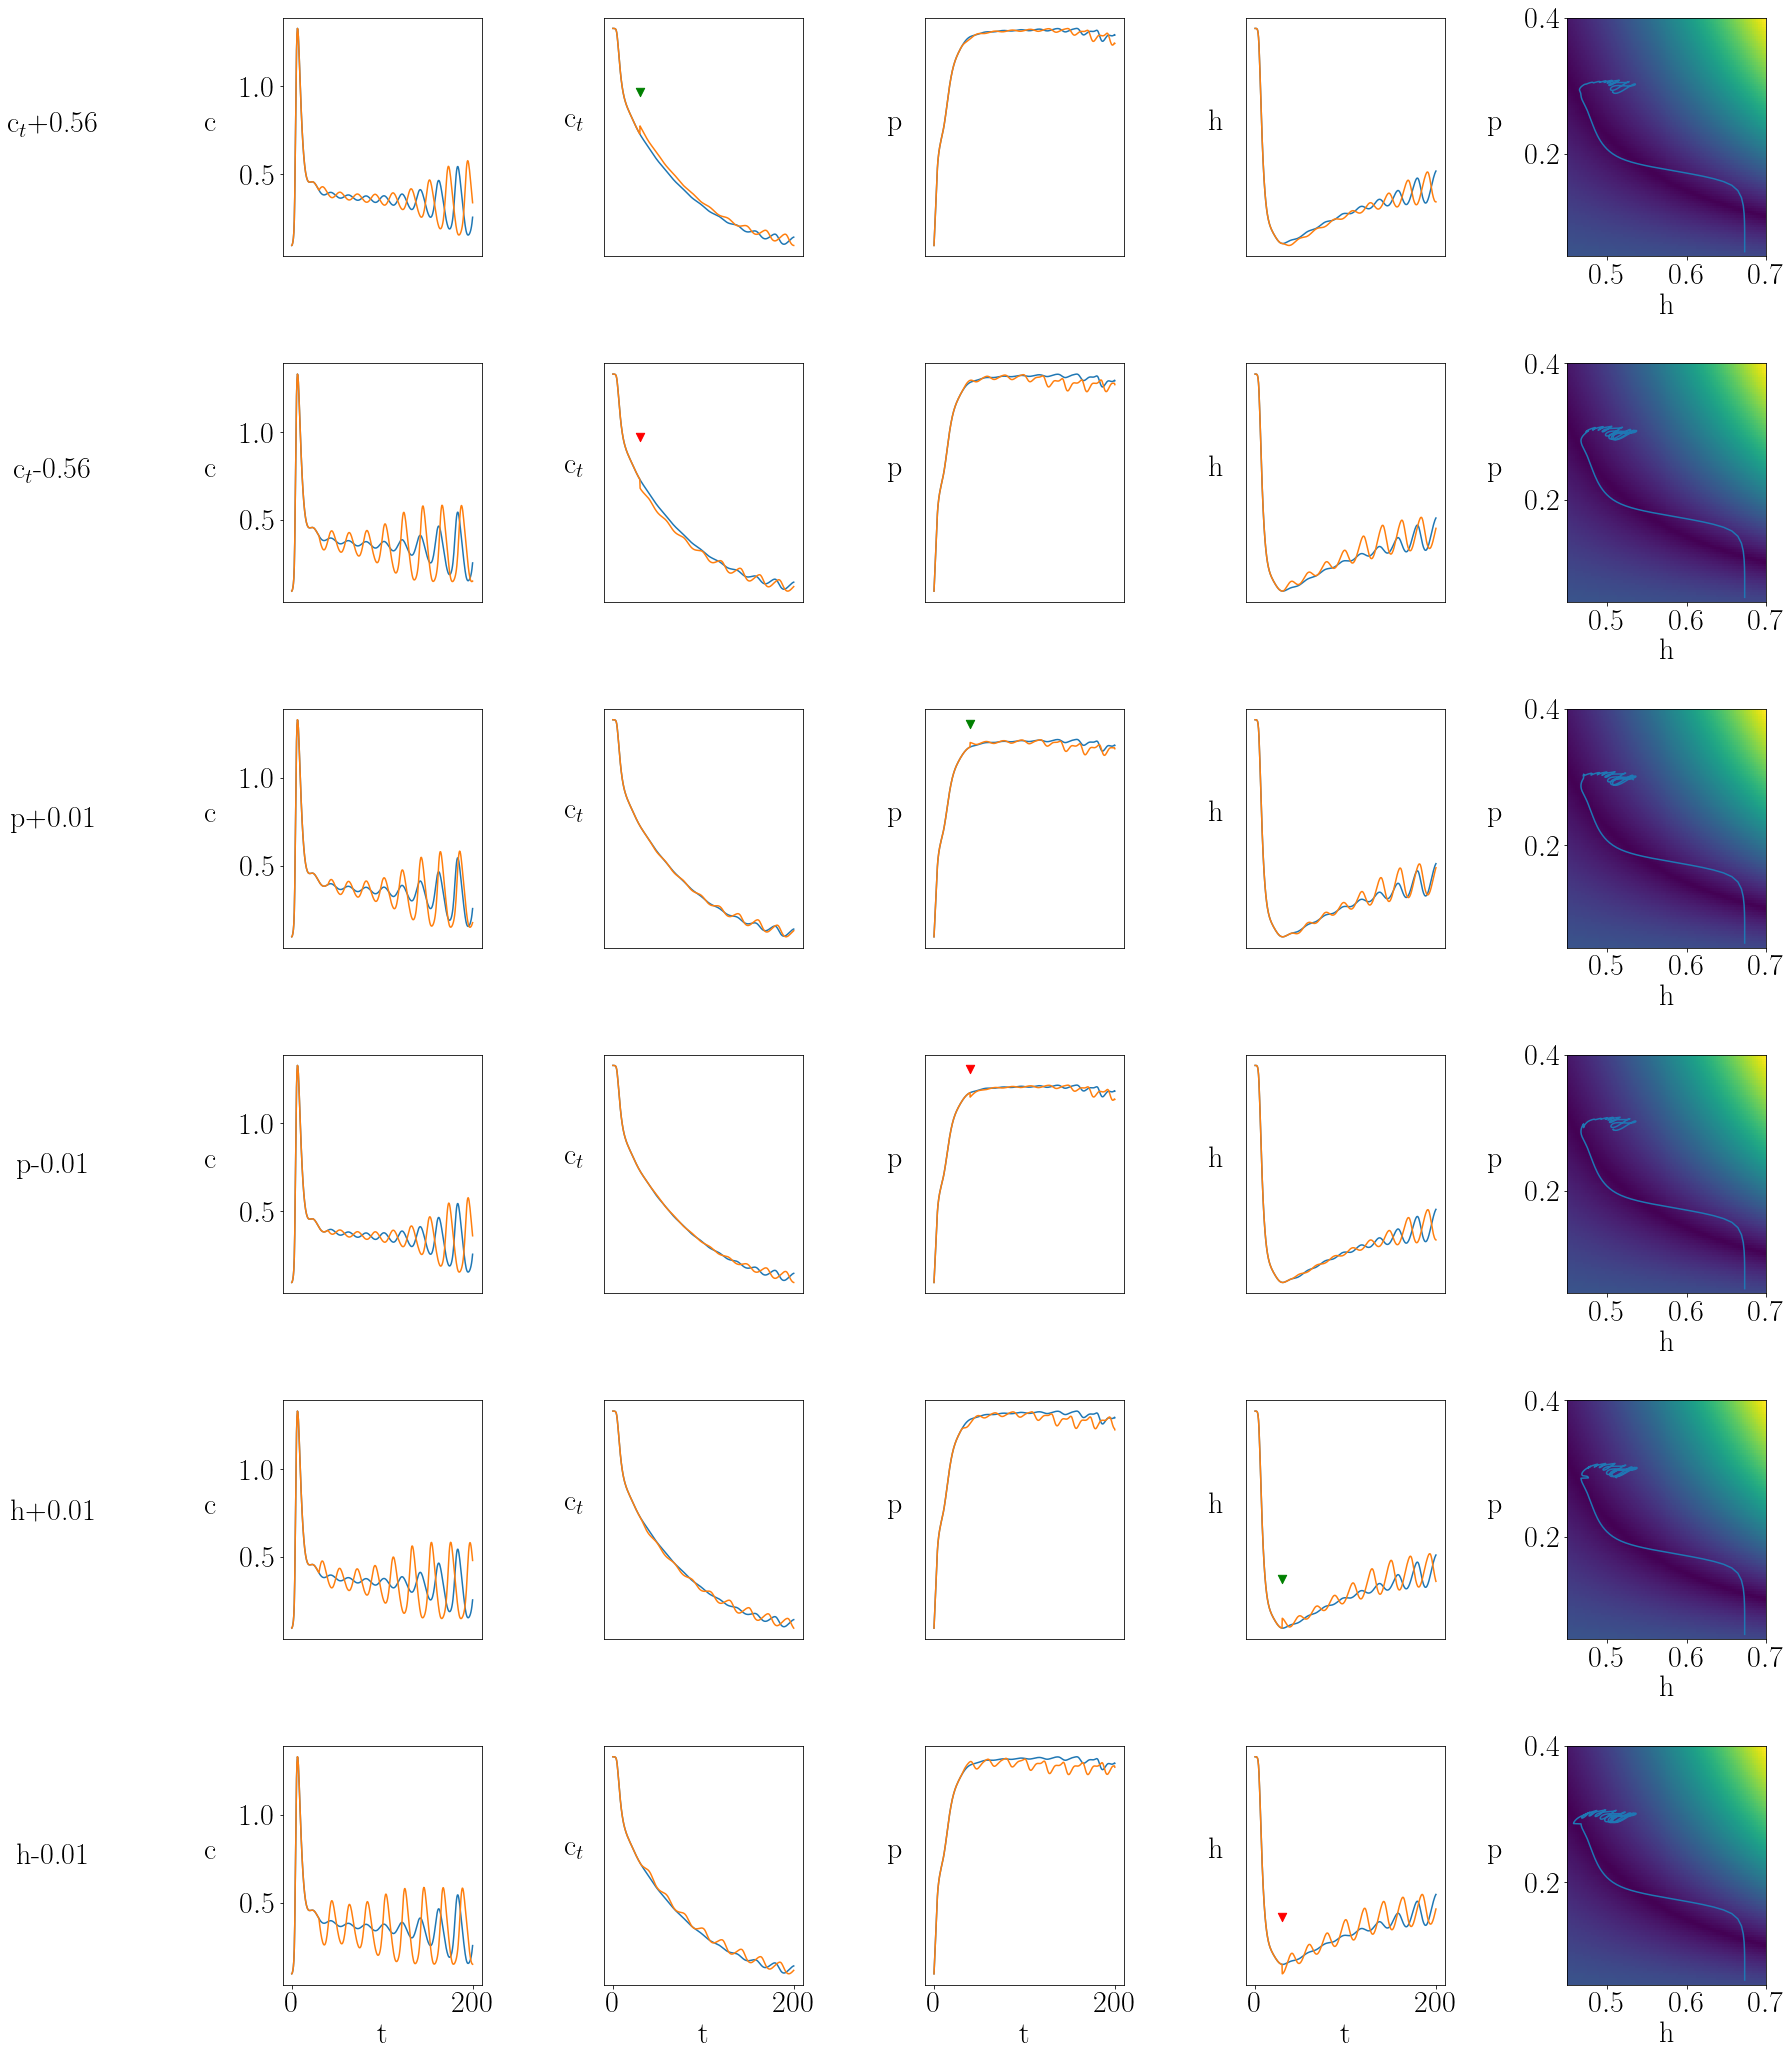

In [94]:
# kicks = [['c_tot', -1, 10], ['c_tot', -1, 70], ['p', 0.02, 10], ['p', -0.02, 70], ['h', 0.05, 10]]
kicks = [['c_tot', ct_kick, 30], ['c_tot', -ct_kick, 30],
        ['p', p_kick, 40], ['p', -p_kick, 40],
        ['h', h_kick, 30], ['h', -h_kick, 30]]
plot_vars = ['c', 'c_tot', 'p', 'h']
y_labels = ['c', 'c$_t$', 'p', 'h']
text_pos = np.linspace(0.9, 0.1, len(kicks))
Gstar = 0.135
cfg.input_max = Gstar

fig, ax = plt.subplots(len(kicks), 5, figsize=(25, len(kicks)*5))

run_Gstar_controlled_experiment('pulse', t_f=200, max_step=0.5)
for i in range(len(kicks)):
    for j in range(4):
        y = getattr(cfg, plot_vars[j])
        ax[i, j].plot(cfg.t, y)
    plot_deriv_speed('c', 'h', 'p', ax=ax[i, 4], plot_from_fp=False, plot_from_exp=False,
                     Gstar=Gstar)

for i in range(len(kicks)):
    #perform kick experiment
    kick = kicks[i]
    
    run_Gstar_kick_experiment(kick_var=kick[0], kick_val=kick[1], kick_t=kick[2])
    
    kick_idx = np.argmax(cfg.t >= kick[2])
    for j in range(4):
        y = getattr(cfg, plot_vars[j])
        ax[i, j].plot(cfg.t, y, label='c$_t$ kick')
        
        if plot_vars.index(kick[0]) == j:
            if kick[1] > 0:
                c = 'green'
            else:
                c = 'red'
            ax[i, j].scatter(cfg.t[kick_idx], y[kick_idx-1] * 1.1, marker='v', s=70, c=c)
        
    ax[i, 4].plot(cfg.h, cfg.p)
    
for i in range(len(kicks)):
    for j in range(4):
        if i != len(kicks) - 1:
            ax[i, j].set_xticks([])
        if j != 0:
            ax[i, j].set_yticks([])
        if j != len(kicks)-1:
            ax[i, j].set_ylabel(y_labels[j], rotation=0, labelpad=30)
        if i == len(kicks)-1 and j != len(kicks)-1:
            ax[i, j].set_xlabel('t')
        
        if j == 0:
            idx = plot_vars.index(kicks[i][0])
            if kicks[i][1] < 0:
                kick_label = y_labels[idx] + str(round(kicks[i][1], 2))
            else:
                kick_label = y_labels[idx] + '+' + str(round(kicks[i][1], 2))
            ax[i, j].text(0.02, text_pos[i], kick_label, fontsize=30, ha='center', 
                transform=plt.gcf().transFigure)

plt.tight_layout()
plt.savefig('figures/delay_plots/4_var_kicks', bbox_inches='tight')
